In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(scales)
library(NICHES)
library(stringr)
library(reshape2)
library(cowplot)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(warn=-1)
set.seed(42)

In [3]:
male_24weeks_rds <- readRDS('../combined_male_24weeks.rds')

In [4]:
Idents(male_24weeks_rds) <- male_24weeks_rds@meta.data$celltype_broad

In [5]:
male_24weeks_rds

An object of class Seurat 
20743 features across 24842 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [6]:
#write.csv(male_8weeks_rds@meta.data[c('sample_type', 'celltype_broad')],'adjacency_metadata.csv')

In [7]:
data.list <- SplitObject(male_24weeks_rds, split.by="sample_type")

In [8]:
data.list <- lapply(X = data.list, FUN = function(x) {
    x <- NormalizeData(x)
})

Normalizing layer: counts

Normalizing layer: counts



In [9]:
data.list[1]
data.list[2]

$taPVAT_Control_24W_M
An object of class Seurat 
20743 features across 11457 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


$taPVAT_HF_24W_M
An object of class Seurat 
20743 features across 13385 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


In [10]:
table(data.list[[1]]@meta.data['celltype_broad'])
table(data.list[[2]]@meta.data['celltype_broad'])

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             7500              2422               660               324 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              125                19               376                31 

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             8924              2411               930               529 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              152                 8               384                47 

In [11]:
#for (i in 1:length(data.list)){
  #Idents(data.list[[i]]) <- data.list[[i]]$sample_type
  #data.list[[i]] <- subset(data.list[[i]],cells = WhichCells(data.list[[i]],downsample = max.cells))
#  Idents(data.list[[i]]) <- data.list[[i]]$celltype_broad
#}

In [12]:
# Run NICHES on each system and store/name the outputs
scc.list <- list()
for(i in 1:length(data.list)){
  print(i)
  scc.list[[i]] <- RunNICHES(data.list[[i]],
                             LR.database="fantom5",
                             species="mouse",
                             assay="RNA",
                             cell_types = "celltype_broad",
                             min.cells.per.ident=1,
                             min.cells.per.gene = 50,
                             meta.data.to.map = c('orig.ident','celltype_broad','sample_type'),
                             SystemToCell = T,
                             CellToCell = T,
                            #CellToNeighborhood = T,
                            #NeighborhoodToCell = T
                            )
}

names(scc.list) <- names(data.list)

[1] 1


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 11457 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 829 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 25677 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 11457 System-To-Cell edges were computed, across 8 cell types



[1] 2


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 13385 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 889 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 30369 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 13385 System-To-Cell edges were computed, across 8 cell types



In [ ]:
cell_counts_df <- as.data.frame(GetAssayData(data.list$taPVAT_Control_24W_M, slot = "counts"))
cell_names <- colnames(cell_counts_df)
adj_matrix <- matrix(0, nrow = length(cell_names), ncol = length(cell_names),
                       dimnames = list(cell_names, cell_names))
cell_pairs <- colnames(as.data.frame(GetAssayData(scc.list$taPVAT_Control_24W_M$CellToCell, slot = "counts")))

for (pair in cell_pairs) {
    cells <- unlist(strsplit(pair, "—"))
    if (all(cells %in% cell_names)) {
      adj_matrix[cells[1], cells[2]] <- 1
    }
  }

write.csv(adj_matrix, file = "male_24weeks_control_adjacency_matrix.csv", row.names = TRUE)

control_metadata <- data.list$taPVAT_Control_24W_M@meta.data[, c("sample_type", "celltype_broad")]
write.csv(control_metadata, file = "male_24weeks_control_metadata.csv", row.names = TRUE)

In [ ]:
sum(adj_matrix == 1)

In [51]:
cell_counts_df <- as.data.frame(GetAssayData(data.list$taPVAT_HF_24W_M, slot = "counts"))
cell_names <- colnames(cell_counts_df)
adj_matrix <- matrix(0, nrow = length(cell_names), ncol = length(cell_names),
                       dimnames = list(cell_names, cell_names))
cell_pairs <- colnames(as.data.frame(GetAssayData(scc.list$taPVAT_HF_24W_M$CellToCell, slot = "counts")))

for (pair in cell_pairs) {
    cells <- unlist(strsplit(pair, "—"))
    if (all(cells %in% cell_names)) {
      adj_matrix[cells[1], cells[2]] <- 1
    }
  }

write.csv(adj_matrix, file = "male_24weeks_hf_adjacency_matrix.csv", row.names = TRUE)

control_metadata <- data.list$taPVAT_HF_24W_M@meta.data[, c("sample_type", "celltype_broad")]
write.csv(control_metadata, file = "male_24weeks_hf_metadata.csv", row.names = TRUE)

In [13]:
sum(adj_matrix == 1)

ERROR: Error in eval(expr, envir, enclos): object 'adj_matrix' not found


In [16]:
temp.list <- list()
for(i in 1:length(scc.list)){
temp.list[[i]] <- scc.list[[i]]$CellToCell 
temp.list[[i]]$Condition <- names(scc.list)[i] 
}

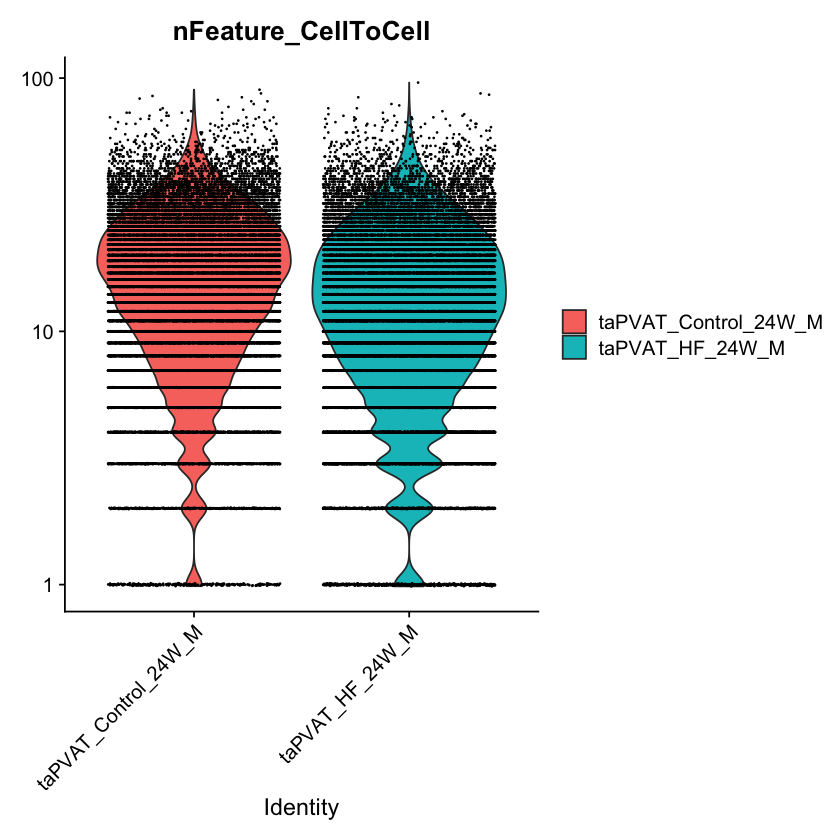

In [17]:
# Merge together
scc.merge <- merge(temp.list[[1]],temp.list[2])

# Clean up low-information crosses (connectivity data can be very sparse)
VlnPlot(scc.merge,features = 'nFeature_CellToCell',group.by = 'Condition',pt.size=0.1,log = T)

In [18]:
scc.sub <- subset(scc.merge,nFeature_CellToCell > 5) # Requesting at least 5 distinct ligand-receptor interactions between two cells

In [19]:
unique(scc.sub$VectorType)

[1] "Endothelial_Cells—Endothelial_Cells" "Endothelial_Cells—Adipocytes"       
 [3] "Endothelial_Cells—Pericytes"         "Endothelial_Cells—Fibroblasts"      
 [5] "Endothelial_Cells—Immune_Cells"      "Endothelial_Cells—SMCs"             
 [7] "Endothelial_Cells—Mesothelial_Cells" "Endothelial_Cells—Neuronal_Cells"   
 [9] "Adipocytes—Endothelial_Cells"        "Adipocytes—Adipocytes"              
[11] "Adipocytes—Pericytes"                "Adipocytes—Fibroblasts"             
[13] "Adipocytes—Immune_Cells"             "Adipocytes—SMCs"                    
[15] "Adipocytes—Mesothelial_Cells"        "Adipocytes—Neuronal_Cells"          
[17] "Pericytes—Endothelial_Cells"         "Pericytes—Adipocytes"               
[19] "Pericytes—Pericytes"                 "Pericytes—Fibroblasts"              
[21] "Pericytes—Immune_Cells"              "Pericytes—SMCs"                     
[23] "Pericytes—Mesothelial_Cells"         "Pericytes—Neuronal_Cells"           
[25] "Fibroblasts—Endothelial_Cells"       "Fibroblasts—Adipocytes"             
[27] "Fibroblasts—Pericytes"               "Fibroblasts—Fibroblasts"            
[29] "Fibroblasts—Immune_Cells"            "Fibroblasts—SMCs"                   
[31] "Fibroblasts—Mesothelial_Cells"       "Fibroblasts—Neuronal_Cells"         
[33] "Immune_Cells—Endothelial_Cells"      "Immune_Cells—Adipocytes"            
[35] "Immune_Cells—Pericytes"              "Immune_Cells—Fibroblasts"           
[37] "Immune_Cells—Immune_Cells"           "Immune_Cells—SMCs"                  
[39] "Immune_Cells—Mesothelial_Cells"      "Immune_Cells—Neuronal_Cells"        
[41] "SMCs—Endothelial_Cells"              "SMCs—Adipocytes"                    
[43] "SMCs—Pericytes"                      "SMCs—Fibroblasts"                   
[45] "SMCs—Immune_Cells"                   "SMCs—SMCs"                          
[47] "SMCs—Mesothelial_Cells"              "SMCs—Neuronal_Cells"                
[49] "Mesothelial_Cells—Endothelial_Cells" "Mesothelial_Cells—Adipocytes"       
[51] "Mesothelial_Cells—Pericytes"         "Mesothelial_Cells—Fibroblasts"      
[53] "Mesothelial_Cells—Immune_Cells"      "Mesothelial_Cells—SMCs"             
[55] "Mesothelial_Cells—Mesothelial_Cells" "Mesothelial_Cells—Neuronal_Cells"   
[57] "Neuronal_Cells—Endothelial_Cells"    "Neuronal_Cells—Adipocytes"          
[59] "Neuronal_Cells—Pericytes"            "Neuronal_Cells—Fibroblasts"         
[61] "Neuronal_Cells—Immune_Cells"         "Neuronal_Cells—SMCs"                
[63] "Neuronal_Cells—Mesothelial_Cells"    "Neuronal_Cells—Neuronal_Cells"

In [20]:
#as.data.frame(GetAssayData(scc.list$taPVAT_Control_8W_M$CellToCell, slot = "counts"))

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Lama2—Itgb1, Col3a1—Itgb1, Col6a2—Itgb1, Col5a2—Itgb1, Fbn1—Itgb1, Col6a3—Itgb1, Col6a1—Itgb1, Lama2—Itga1, Col1a2—Itgb1, Col4a4—Itgb1 
	   Col6a2—Itga1, Col1a1—Itgb1, Col6a3—Itga1, Col4a3—Itgb1, Col5a2—Itga1, Col5a1—Itgb1, Col6a1—Itga1, Adam12—Itgb1, Col4a1—Itgb1, Col1a2—Itga1 
	   Col4a4—Itga1, Lamc1—Itgb1, Nid1—Itgb1, Lama4—Itgb1, Col1a1—Itga1, Col4a3—Itga1, Lama2—Itga6, Col5a1—Itga1, Angpt1—Itgb1, Hspg2—Itgb1 
Negative:  Vegfa—Nrp1, Sorbs1—Insr, Gnas—Adcy9, Gnas—Adrb3, Lpl—Lrp1, Adipoq—Adipor2, Vegfa—Nrp2, Nrg4—Erbb4, Nampt—Insr, Vegfa—Itgav 
	   Gnas—Adora1, Sorbs1—Itgb5, Psap—Lrp1, Sorbs1—Itga1, Fgf1—Nrp1, Fgf1—Fgfr1, Hspg2—Ptprs, Tfpi—Lrp1, Gnas—Tshr, Vegfb—Nrp1 
	   Psap—Sort1, Nrg2—Erbb4, Farp2—Plxna2, Lpl—Vldlr, Adam17—Erbb4, Gnas—Gcgr, Ltbp3—Itgb5, Calm1—Insr, Vegfa—Sirpa, Adipoq—Adipor1 
PC_ 2 
Positive:  Lama4—Itga6, Vegfa—Flt1, Lamc1

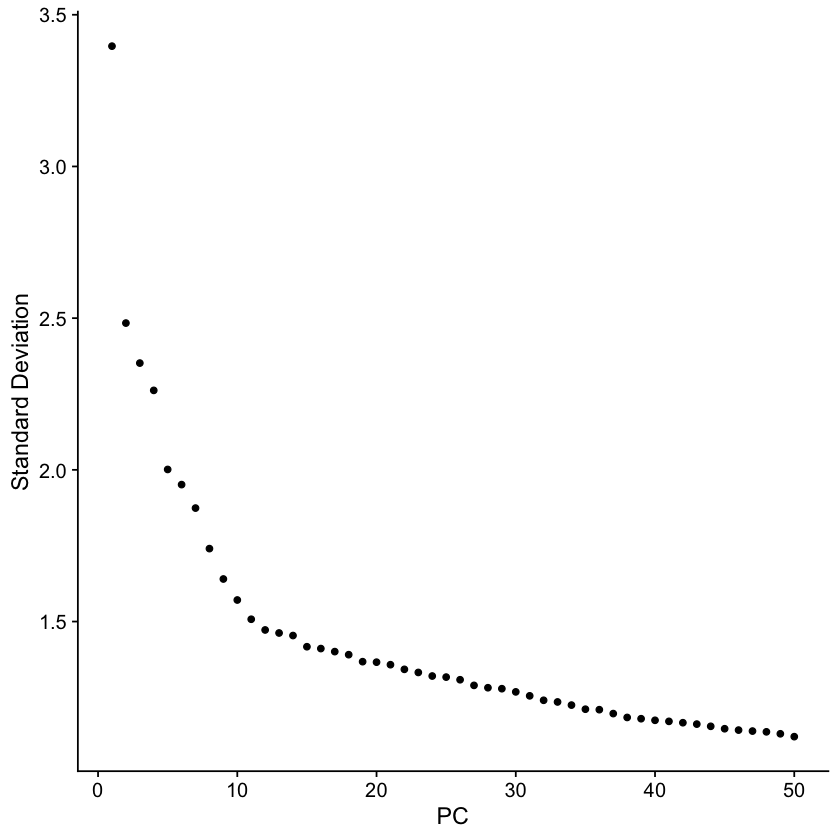

In [21]:
# Perform initial visualization
scc.sub <- ScaleData(scc.sub)
scc.sub <- FindVariableFeatures(scc.sub,selection.method = "disp")
scc.sub <- RunPCA(scc.sub,npcs = 50)
ElbowPlot(scc.sub,ndim=50)

18:39:04 UMAP embedding parameters a = 0.9922 b = 1.112

18:39:04 Read 45536 rows and found 25 numeric columns

18:39:04 Using Annoy for neighbor search, n_neighbors = 30

18:39:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:39:07 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpcFZpAi/file23bd304c7e9f

18:39:07 Searching Annoy index using 1 thread, search_k = 3000

18:39:21 Annoy recall = 100%

18:39:21 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:39:23 Initializing from normalized Laplacian + noise (using RSpectra)

18:39:24 Commencing optimization for 200 epochs, with 1970448 positive edges

18:40:06 Optimization finished



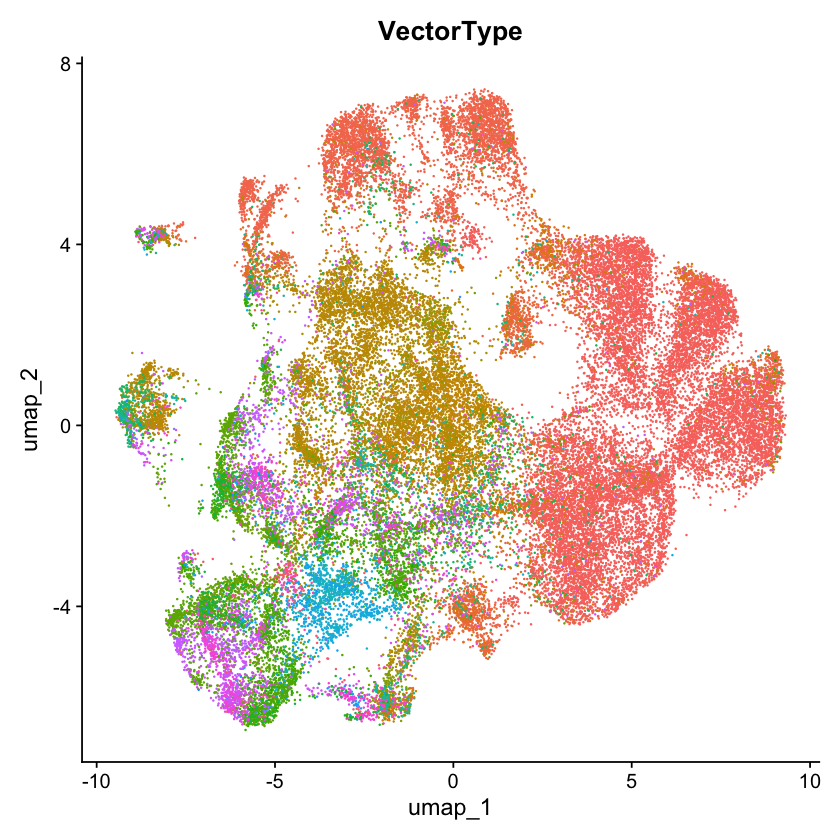

In [22]:
scc.sub <- RunUMAP(scc.sub,dims = 1:25)
DimPlot(scc.sub,group.by = 'VectorType')+NoLegend()

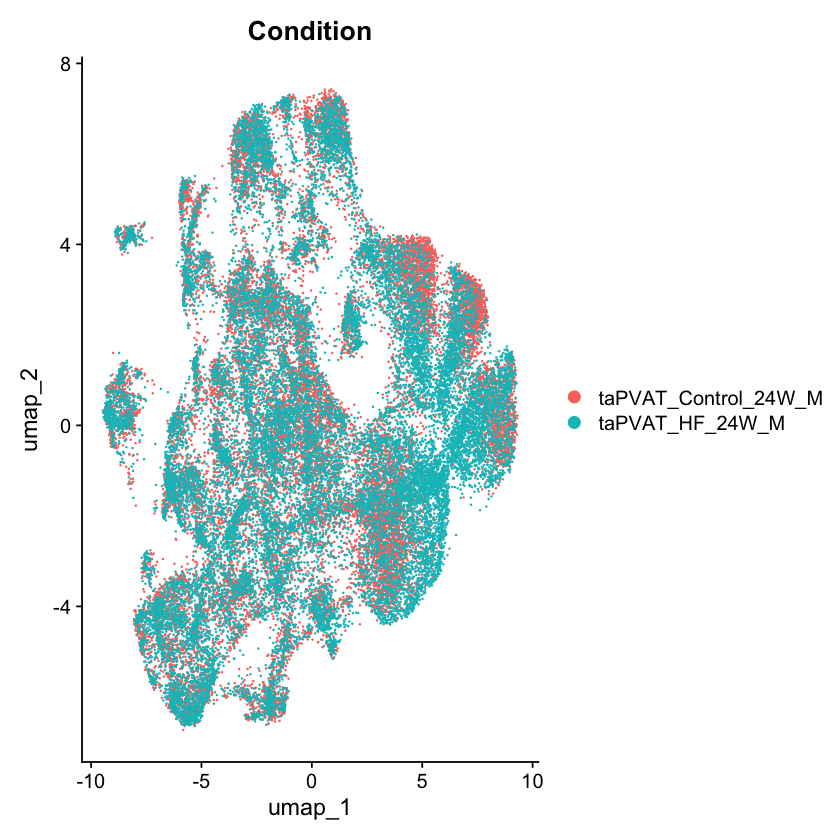

In [23]:
DimPlot(scc.sub,group.by = 'Condition')

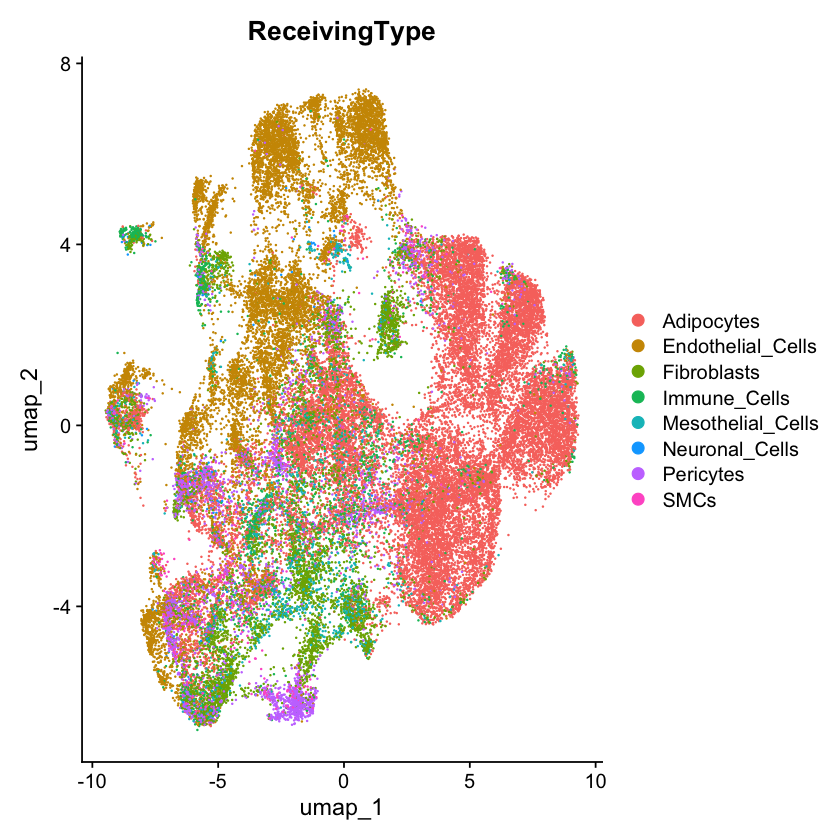

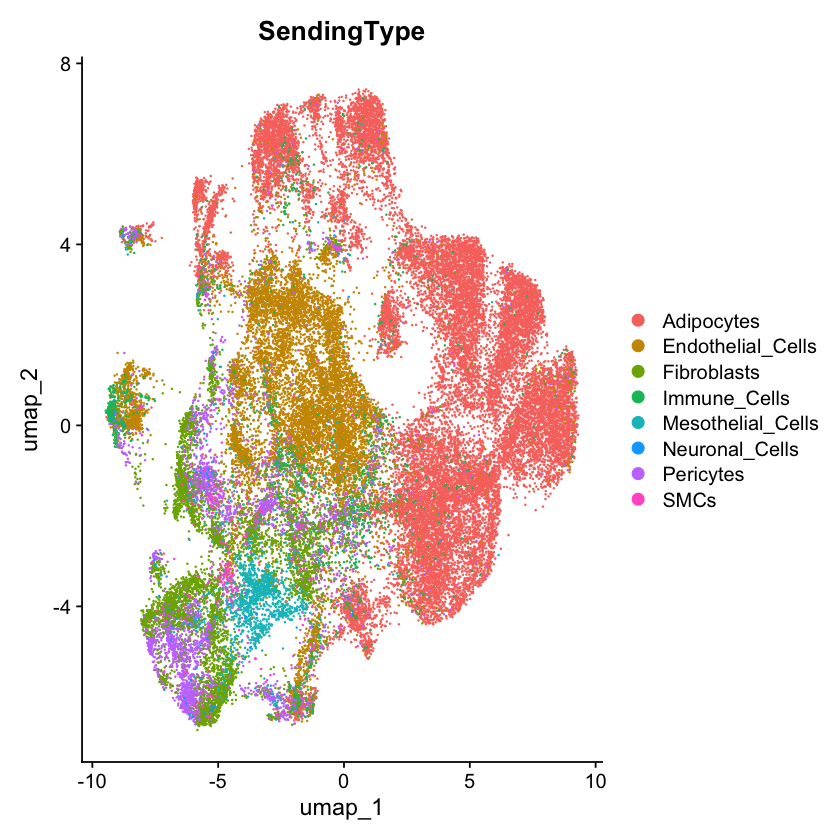

In [24]:
DimPlot(scc.sub,group.by = 'ReceivingType')
DimPlot(scc.sub,group.by = 'SendingType')

In [25]:
table(scc.sub@meta.data$VectorType)


              Adipocytes—Adipocytes        Adipocytes—Endothelial_Cells 
                              15074                                4483 
             Adipocytes—Fibroblasts             Adipocytes—Immune_Cells 
                               1362                                 521 
       Adipocytes—Mesothelial_Cells           Adipocytes—Neuronal_Cells 
                                215                                  19 
               Adipocytes—Pericytes                     Adipocytes—SMCs 
                                650                                  75 
       Endothelial_Cells—Adipocytes Endothelial_Cells—Endothelial_Cells 
                               3936                                3861 
      Endothelial_Cells—Fibroblasts      Endothelial_Cells—Immune_Cells 
                               1167                                 430 
Endothelial_Cells—Mesothelial_Cells    Endothelial_Cells—Neuronal_Cells 
                                202               

In [26]:
rownames(GetAssayData(scc.sub, assay = "CellToCell", slot = "scale.data"))


[1] "Ace—Bdkrb2"        "Adam10—Axl"        "Adam10—Epha3"     
  [4] "Adam12—Itga9"      "Adam12—Itgb1"      "Adam12—Sdc4"      
  [7] "Adam15—Itga5"      "Adam15—Itga9"      "Adam15—Itgav"     
 [10] "Adam15—Itgb1"      "Adam15—Itgb3"      "Adam17—Erbb4"     
 [13] "Adam17—Itga5"      "Adam17—Itgb1"      "Adam17—Notch1"    
 [16] "Adam23—Itga5"      "Adam23—Itgb3"      "Adam9—Itga3"      
 [19] "Adam9—Itga6"       "Adam9—Itgav"       "Adam9—Itgb1"      
 [22] "Adam9—Itgb5"       "Adipoq—Adipor1"    "Adipoq—Adipor2"   
 [25] "Adm—Calcrl"        "Adm—Gpr182"        "Agrn—Lrp4"        
 [28] "Angpt1—Itga5"      "Angpt1—Itgb1"      "Angpt1—Tek"       
 [31] "Angpt1—Tie1"       "Angpt2—Tek"        "Angpt2—Tie1"      
 [34] "Angpt4—Tek"        "Angpt4—Tie1"       "Angptl1—Tek"      
 [37] "Angptl2—Tie1"      "Angptl3—Itga5"     "Angptl3—Itgav"    
 [40] "Angptl3—Itgb3"     "Angptl4—Tie1"      "Anxa1—Dysf"       
 [43] "Anxa1—Egfr"        "Apoe—Ldlr"         "Apoe—Lrp1"        
 [46] "Apoe—Lrp5"         "Apoe—Scarb1"       "Apoe—Sorl1"       
 [49] "Apoe—Vldlr"        "App—Cav1"          "App—Cd74"         
 [52] "App—Lrp1"          "App—Ncstn"         "App—Ngfr"         
 [55] "App—Slc45a3"       "App—Tnfrsf21"      "Artn—Gfra1"       
 [58] "B2m—Cd247"         "B2m—Tfrc"          "Bgn—Ly96"         
 [61] "Bgn—Tlr4"          "Bmp4—Acvr1"        "Bmp4—Acvr2a"      
 [64] "Bmp4—Acvr2b"       "Bmp4—Bmpr1a"       "Bmp4—Bmpr1b"      
 [67] "Bmp4—Bmpr2"        "Bmp5—Acvr1"        "Bmp5—Acvr2a"      
 [70] "Bmp5—Acvr2b"       "Bmp5—Bmpr1a"       "Bmp5—Bmpr1b"      
 [73] "Bmp5—Bmpr2"        "Bmp6—Acvr1"        "Bmp6—Acvr2a"      
 [76] "Bmp6—Acvr2b"       "Bmp6—Bmpr1a"       "Bmp6—Bmpr1b"      
 [79] "Bmp6—Bmpr2"        "Btc—Egfr"          "Btc—Erbb4"        
 [82] "C1qa—Cd93"         "C1qa—Cspg4"        "C4b—Cd46"         
 [85] "Calm1—Abca1"       "Calm1—Adcyap1r1"   "Calm1—Cacna1c"    
 [88] "Calm1—Egfr"        "Calm1—Fas"         "Calm1—Glp2r"      
 [91] "Calm1—Grm4"        "Calm1—Insr"        "Calm1—Kcnn4"      
 [94] "Calm1—Kcnq1"       "Calm1—Kcnq5"       "Calm1—Mylk"       
 [97] "Calm1—Pde1a"       "Calm1—Pde1b"       "Calm1—Pde1c"      
[100] "Calm1—Ptpra"       "Calm1—Sctr"        "Calm1—Trpc3"      
[103] "Calm1—Trpc5"       "Calm2—Abca1"       "Calm2—Egfr"       
[106] "Calm2—Insr"        "Calm2—Kcnq1"       "Calm2—Kcnq5"      
[109] "Calm2—Mylk"        "Calm2—Pde1a"       "Calm2—Pde1b"      
[112] "Calm2—Pde1c"       "Calm2—Trpc5"       "Calr—Itga2b"      
[115] "Calr—Itga3"        "Calr—Itgav"        "Calr—Lrp1"        
[118] "Calr—Scarf1"       "Calr—Tshr"         "Ccl27—Ccr10"      
[121] "Cfh—Itgam"         "Cgn—F11r"          "Cgn—Ocln"         
[124] "Cgn—Tgfbr1"        "Cgn—Tgfbr2"        "Clcf1—Cntfr"      
[127] "Clcf1—Crlf1"       "Clcf1—Il6st"       "Clcf1—Lifr"       
[130] "Cntf—Cntfr"        "Cntf—Il6st"        "Cntf—Lifr"        
[133] "Cntn4—Ptprg"       "Col14a1—Cd44"      "Col18a1—Gpc4"     
[136] "Col18a1—Itga5"     "Col18a1—Itgb1"     "Col18a1—Kdr"      
[139] "Col1a1—Cd44"       "Col1a1—Cd93"       "Col1a1—Ddr2"      
[142] "Col1a1—Flt4"       "Col1a1—Itga1"      "Col1a1—Itga11"    
[145] "Col1a1—Itga2"      "Col1a1—Itga5"      "Col1a1—Itgav"     
[148] "Col1a1—Itgb1"      "Col1a2—Cd44"       "Col1a2—Cd93"      
[151] "Col1a2—Flt4"       "Col1a2—Itga1"      "Col1a2—Itga11"    
[154] "Col1a2—Itga2"      "Col1a2—Itga2b"     "Col1a2—Itgav"     
[157] "Col1a2—Itgb1"      "Col1a2—Itgb3"      "Col3a1—Ddr2"      
[160] "Col3a1—Itga2"      "Col3a1—Itgb1"      "Col4a1—Cd47"      
[163] "Col4a1—Cd93"       "Col4a1—Itga1"      "Col4a1—Itga2"     
[166] "Col4a1—Itgav"      "Col4a1—Itgb1"      "Col4a1—Itgb8"     
[169] "Col4a2—Cd93"       "Col4a3—Cd47"       "Col4a3—Cd93"      
[172] "Col4a3—Itga1"      "Col4a3—Itga2"      "Col4a3—Itgav"     
[175] "Col4a3—Itgb1"      "Col4a4—Cd47"       "Col4a4—Cd93"      
[178] "Col4a4—Itga1"      "Col4a4—Itga2"      "Col4a4—Itgav"     
[181] "Col4a4—Itgb1"      "Col4a5—Cd47"   

In [27]:

# Loop over VectorTypes of interest, subsetting those interactions, finding markers associated with the comparison of interest (stimulus vs control) and  create a heatmap of top markers:

celltocell_heatmap <- function(VOI) {
    
results <- lapply(VOI, function(x){
 
  #subset
  subs <- subset(scc.sub, subset = VectorType == x)
  subs <- JoinLayers(subs, layers = c("data", "scale.data"))
  
  #print number of cells per condition
  print(paste0(x , ":  taPVAT_Control_24W_M:", sum(subs@meta.data$Condition == "taPVAT_Control_24W_M")))
  print(paste0(x , ":  taPVAT_HF_24W_M:", sum(subs@meta.data$Condition == "taPVAT_HF_24W_M")))
  
  #set idents
  Idents(subs) <- subs@meta.data$Condition
  
  #scale the subsetted data
  FindVariableFeatures(subs,assay='CellToCell',selection.method = "disp")
  ScaleData(subs, assay='CellToCell')
  
  #these are the features in the scaledata slot
  feats <- rownames(GetAssayData(subs, assay = "CellToCell", slot = "scale.data"))
  feats
  
  #find markers (here we use wilcox, but ROC and other tests can be used as well)
  markers <- FindAllMarkers(subs, features=feats, test.use = "wilcox",assay='CellToCell')
  
  #subset to top 10 markers per condition
  top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
  markers_all <- markers %>% group_by(cluster)
    
  list(subs = subs, top10 = top10)
  #Make a heatmap
  #plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top DE Mechanisms, CTRL vs STIM: ",x)
  
})
    return(results)
}

[1] "Fibroblasts—Adipocytes:  taPVAT_Control_24W_M:617"
[1] "Fibroblasts—Adipocytes:  taPVAT_HF_24W_M:823"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_24W_M

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster taPVAT_HF_24W_M



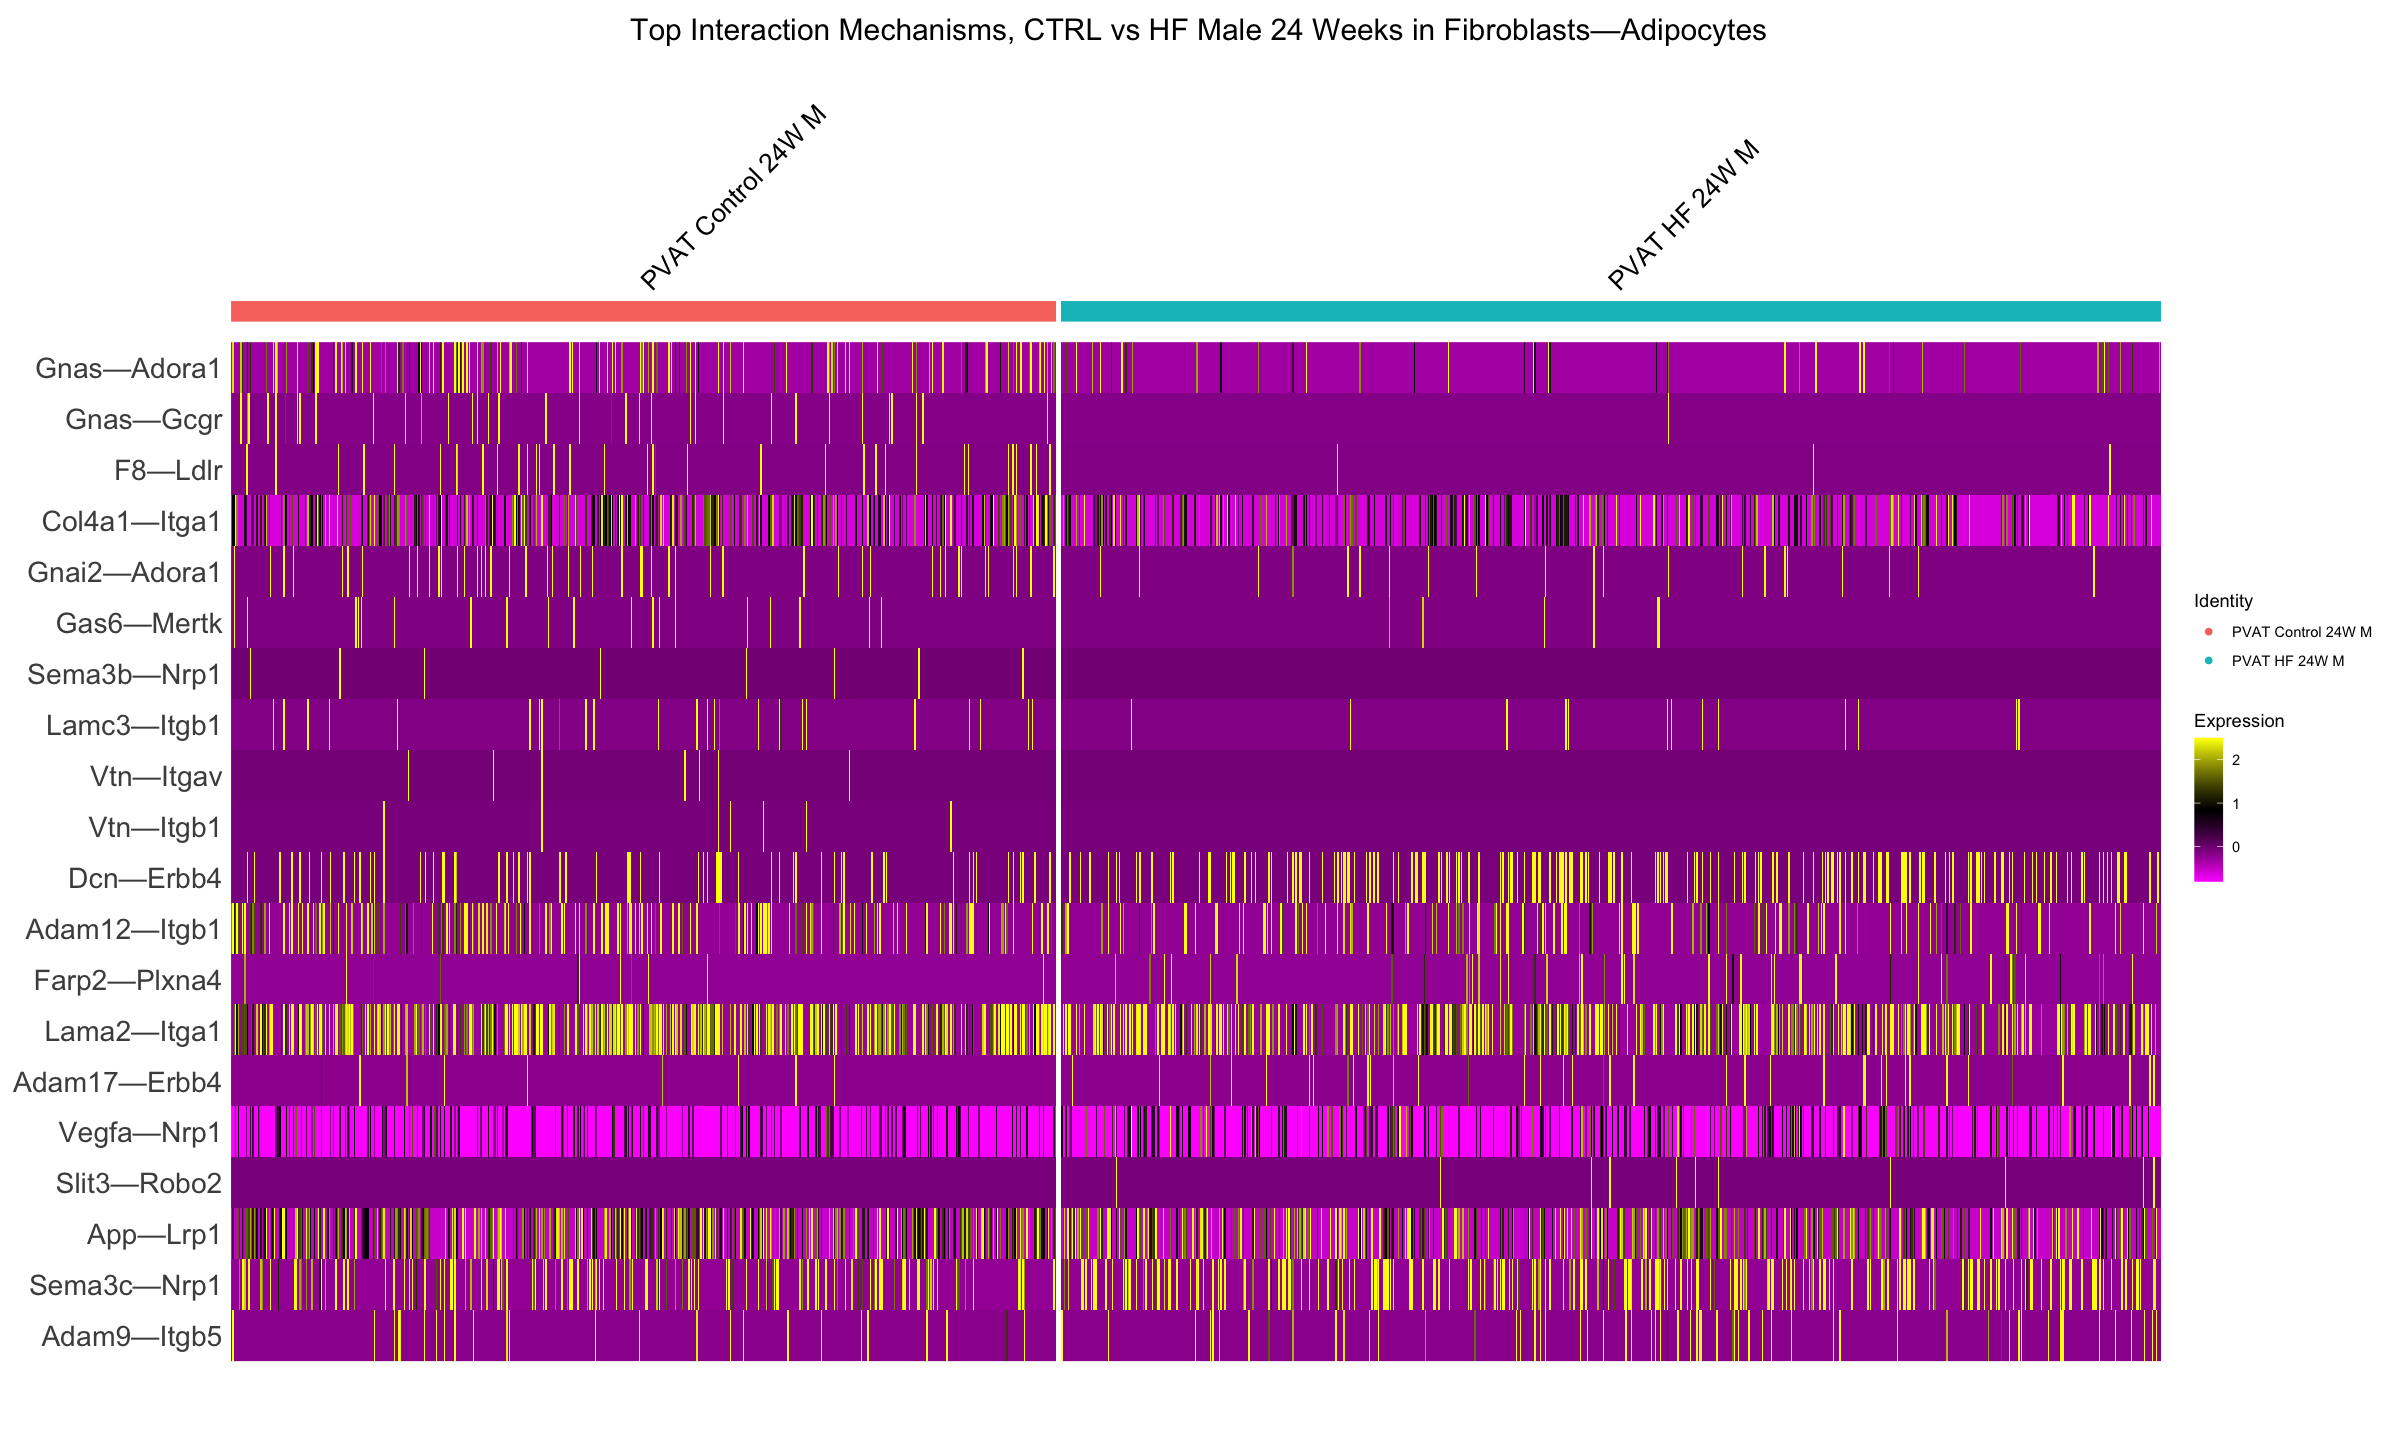

In [28]:
fibro_adipo <- celltocell_heatmap("Fibroblasts—Adipocytes")

options(repr.plot.width=20, repr.plot.height=12)
subs <- fibro_adipo[[1]]$subs
top10 <- fibro_adipo[[1]]$top10

Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_24W_M", "taPVAT_HF_24W_M"), 
                        labels = c("PVAT Control 24W M", "PVAT HF 24W M"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Male 24 Weeks in Fibroblasts—Adipocytes") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Male 24 Weeks in Fibroblasts—Adipocytes.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Fibroblasts:  taPVAT_Control_24W_M:589"
[1] "Adipocytes—Fibroblasts:  taPVAT_HF_24W_M:773"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_24W_M

Calculating cluster taPVAT_HF_24W_M



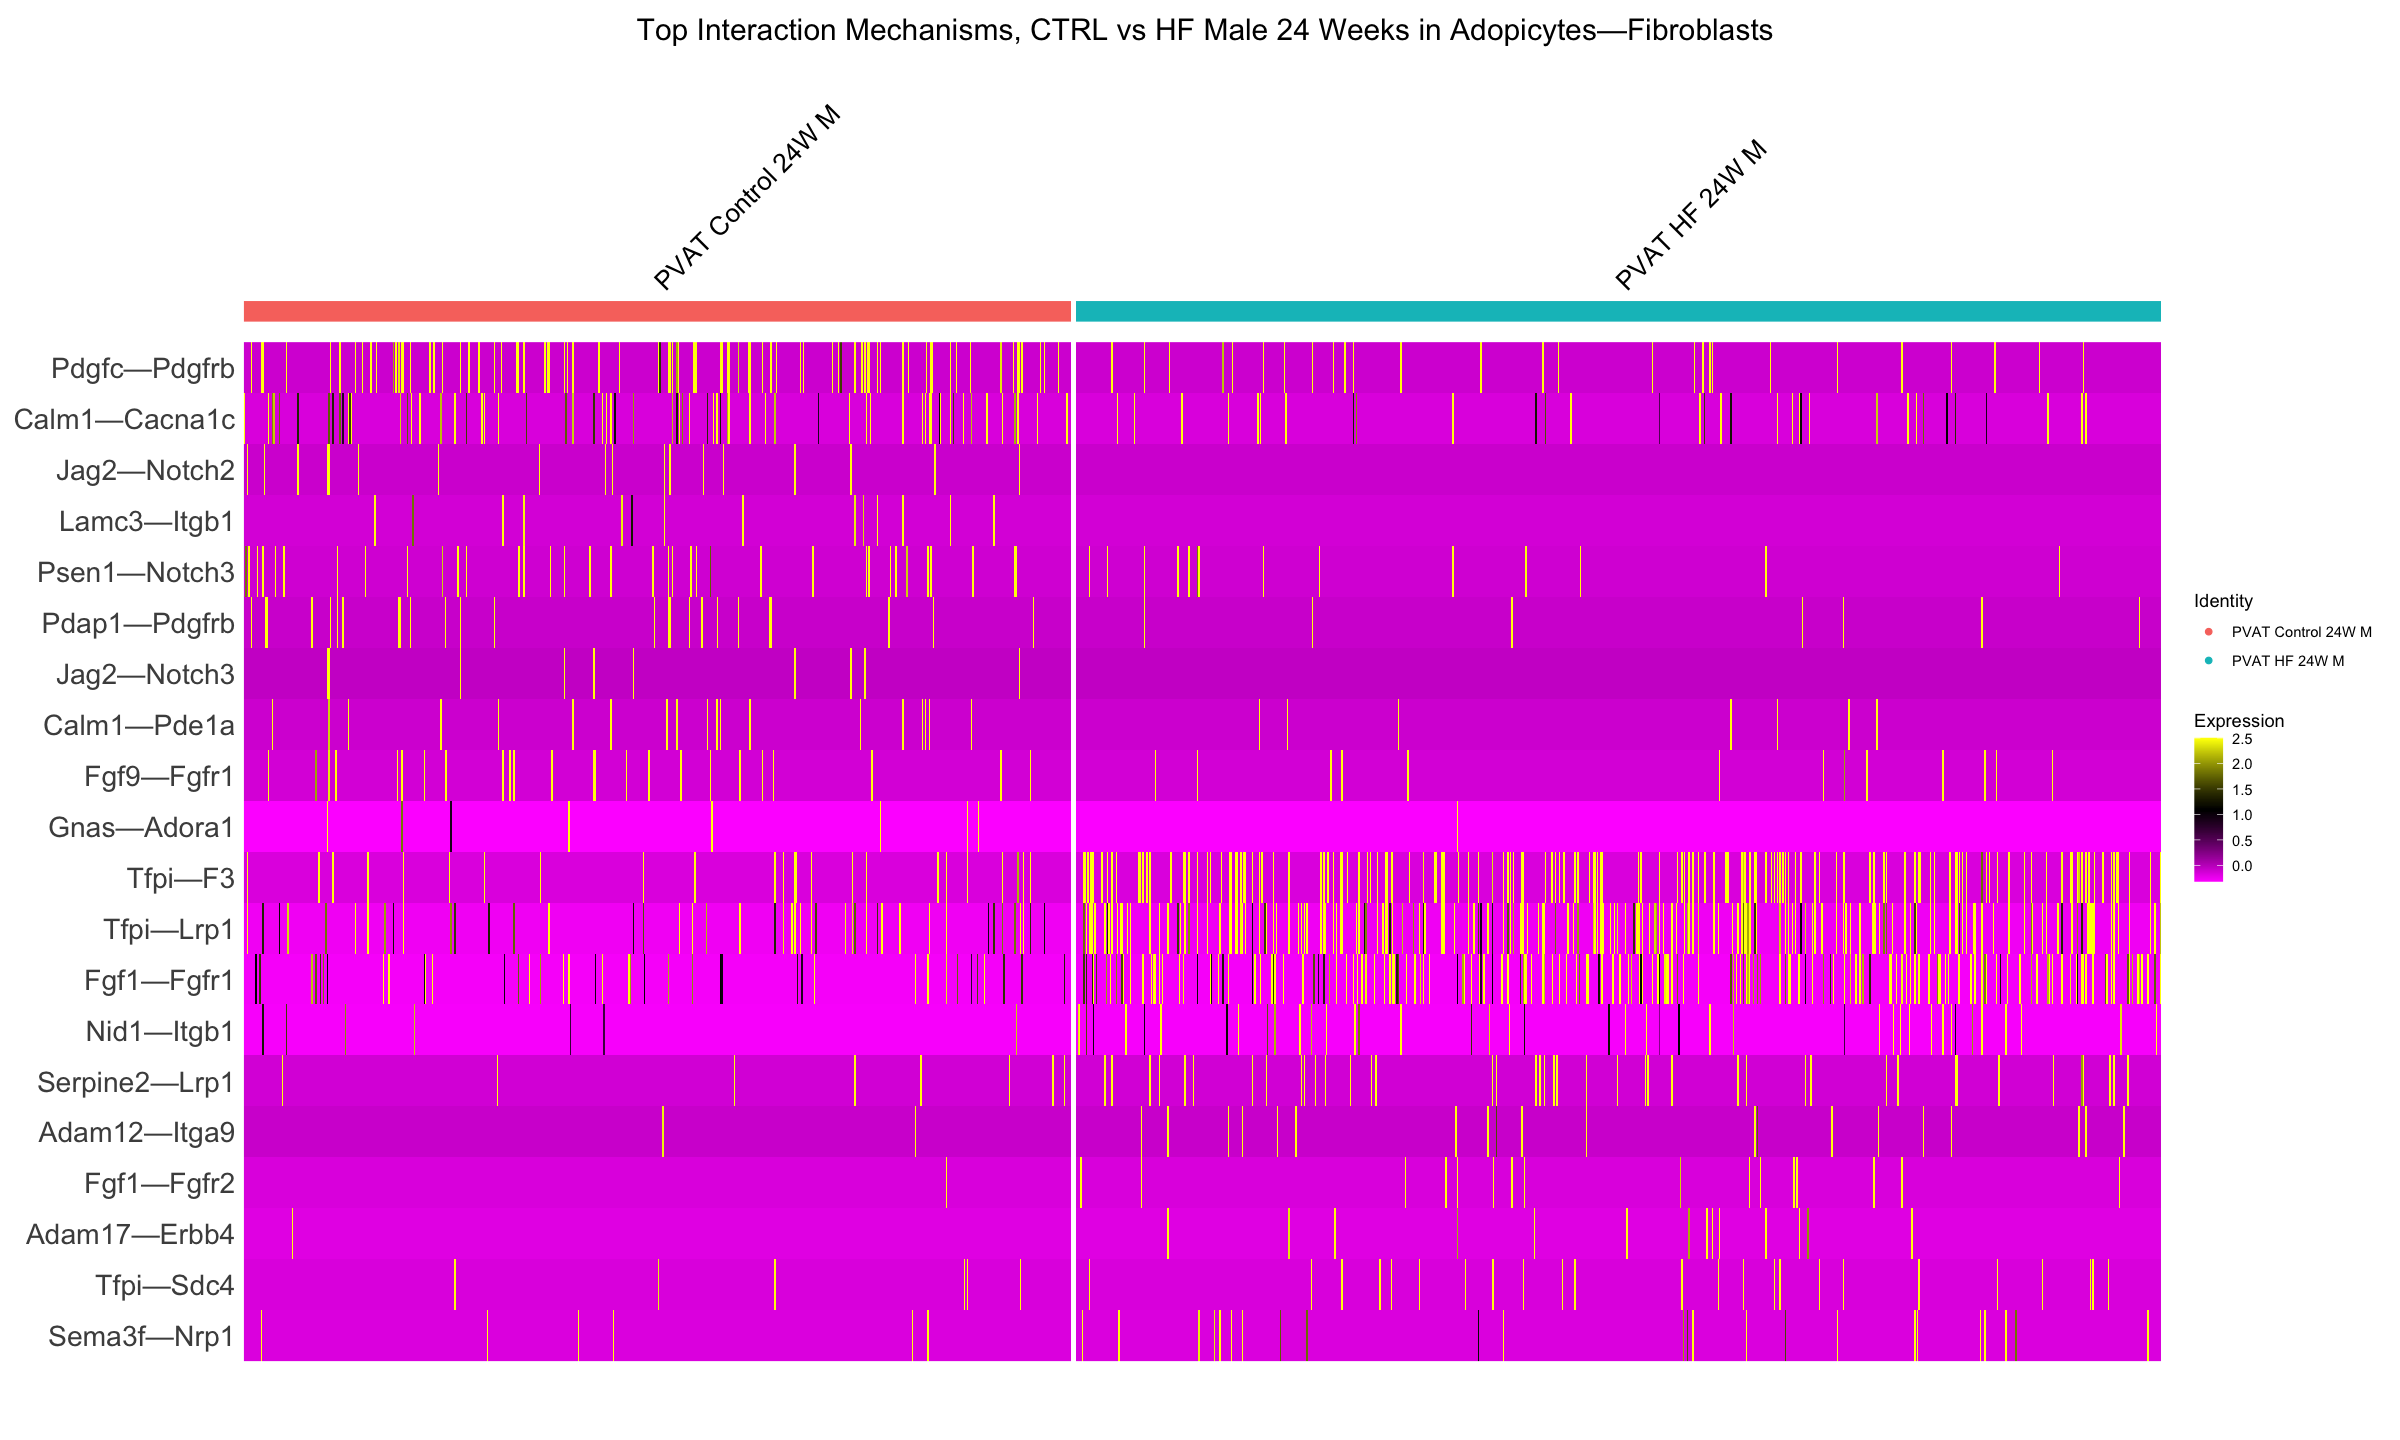

In [29]:
adipo_fibro <- celltocell_heatmap("Adipocytes—Fibroblasts")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_fibro[[1]]$subs
top10 <- adipo_fibro[[1]]$top10
Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_24W_M", "taPVAT_HF_24W_M"), 
                        labels = c("PVAT Control 24W M", "PVAT HF 24W M"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Male 24 Weeks in Adopicytes—Fibroblasts") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Male 24 Weeks in Adopicytes—Fibroblasts.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Endothelial_Cells:  taPVAT_Control_24W_M:2297"
[1] "Adipocytes—Endothelial_Cells:  taPVAT_HF_24W_M:2186"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_24W_M

Calculating cluster taPVAT_HF_24W_M



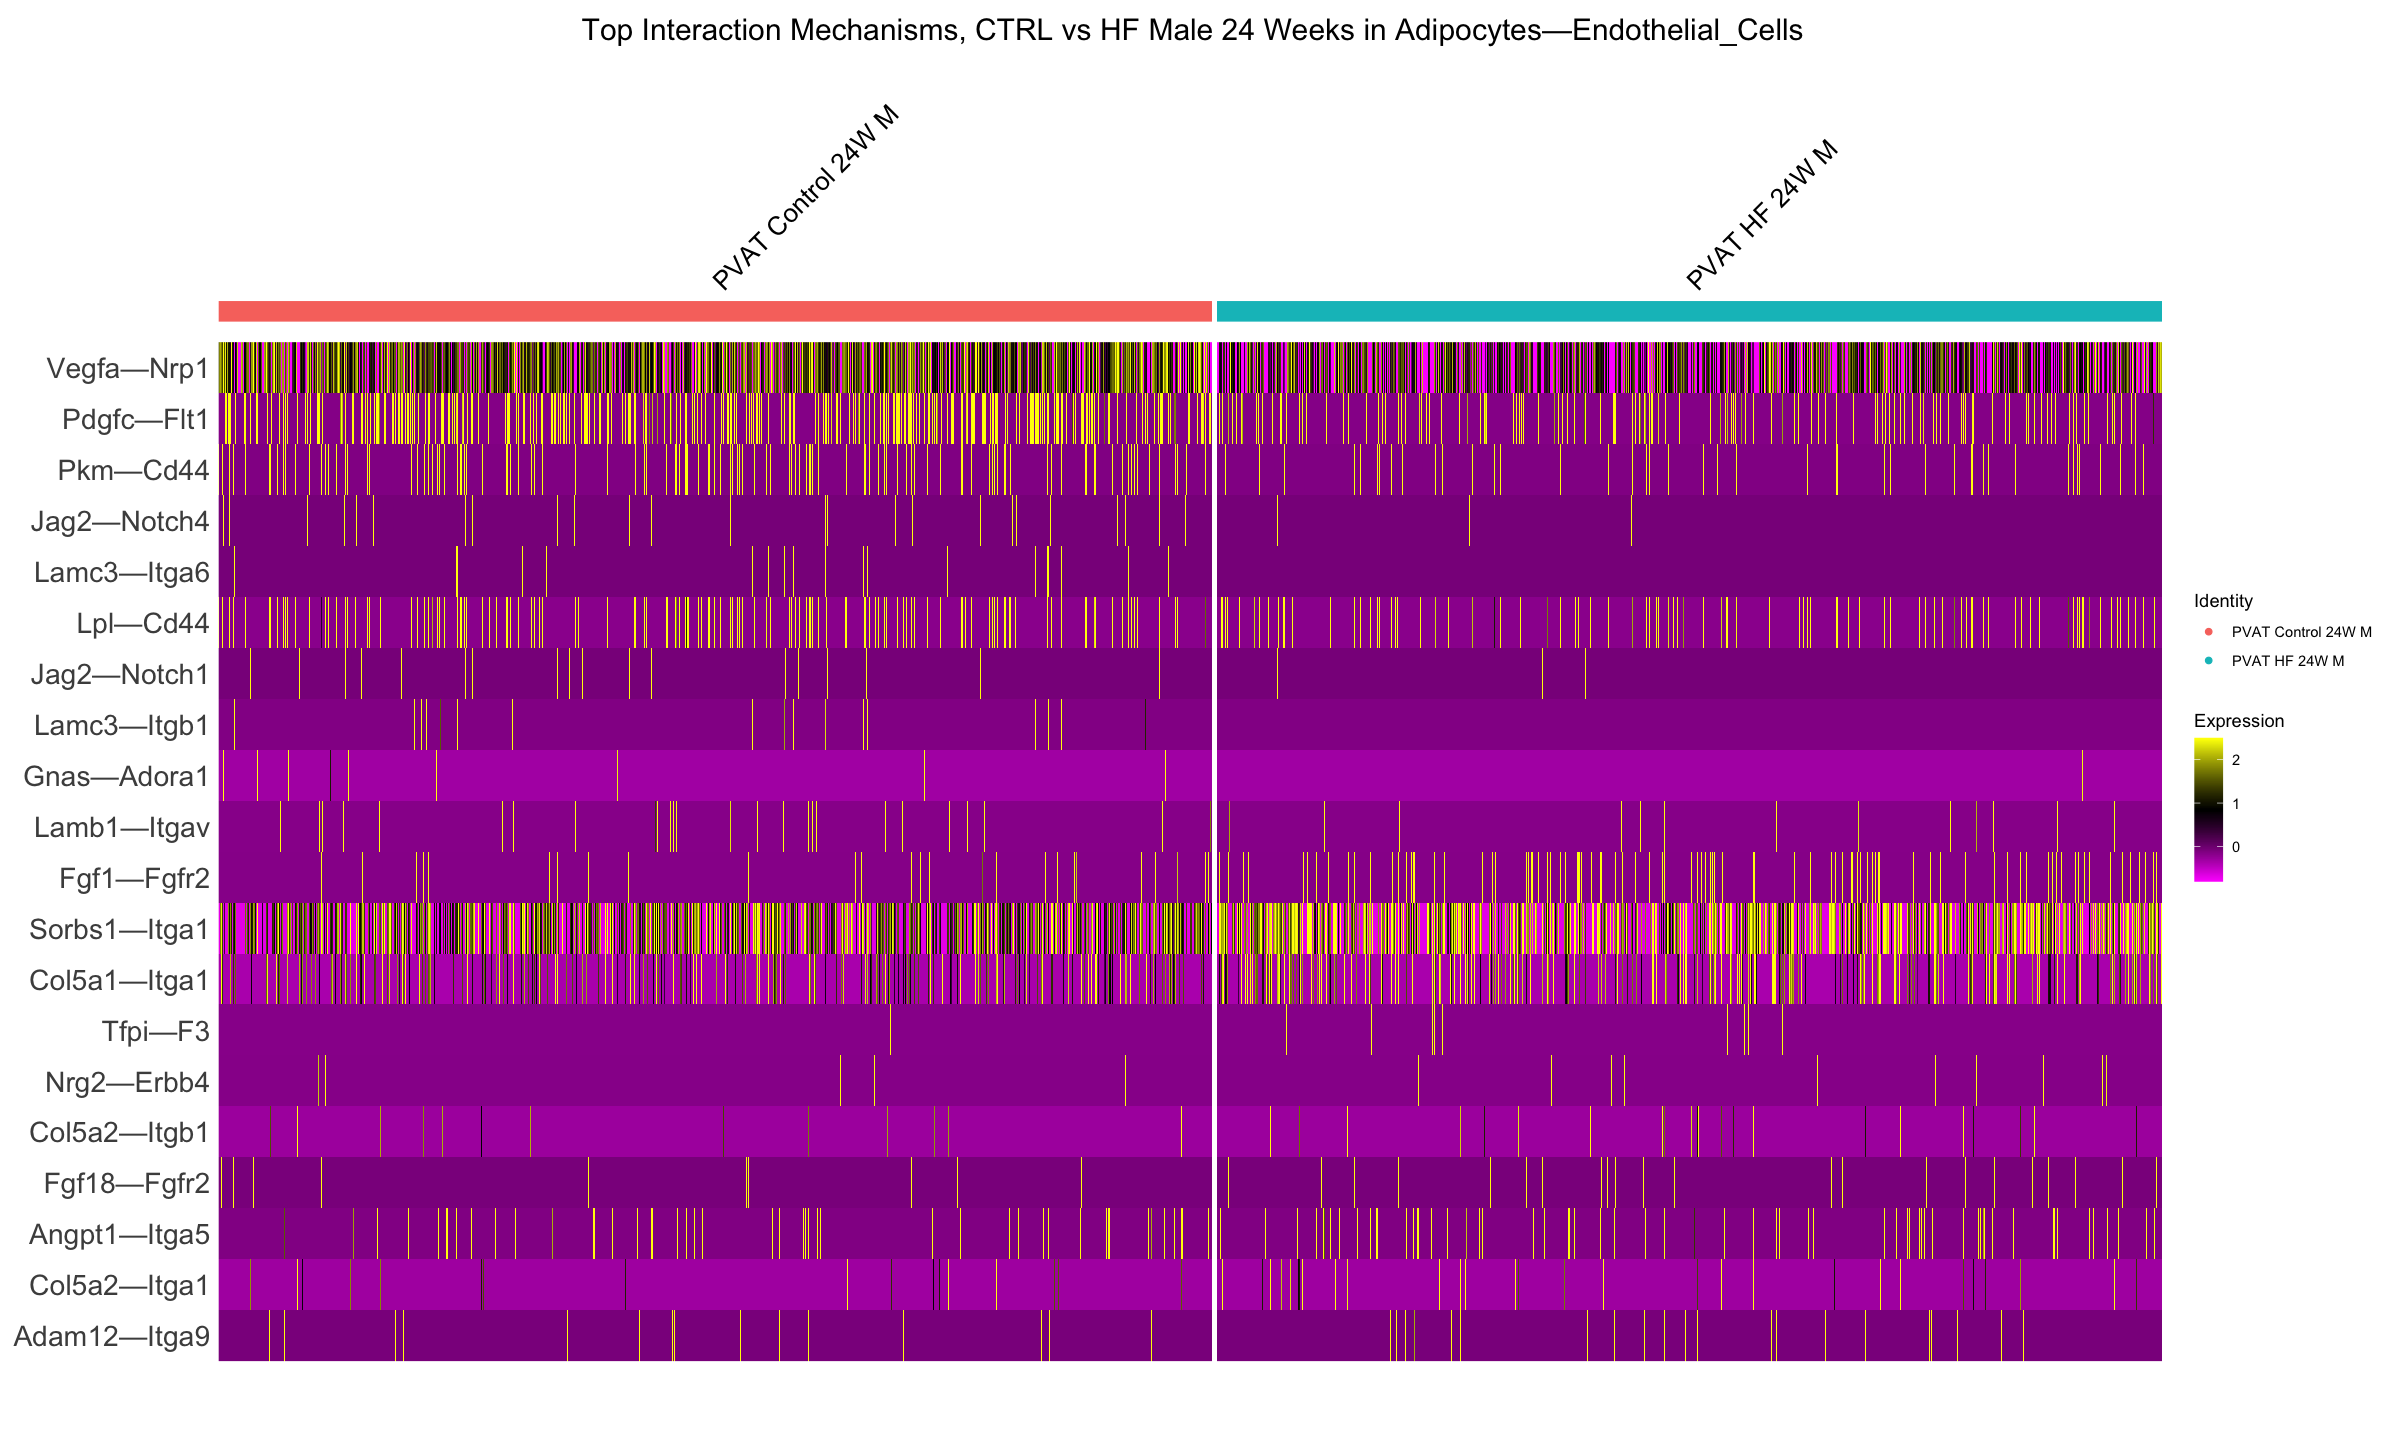

In [30]:
adipo_endo <- celltocell_heatmap("Adipocytes—Endothelial_Cells")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_endo[[1]]$subs
top10 <- adipo_endo[[1]]$top10
markers_all <- adipo_endo[[1]]$markers_all

Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_24W_M", "taPVAT_HF_24W_M"), 
                        labels = c("PVAT Control 24W M", "PVAT HF 24W M"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Male 24 Weeks in Adipocytes—Endothelial_Cells") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Male 24 Weeks in Adipocytes—Endothelial_Cells.pdf", plot = plot, width = 20, height = 12, dpi = 600)

In [31]:
markers_all

NULL

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Lama4—Itgb1, Vegfa—Itgb1, Col4a1—Itgb1, Lamc1—Itgb1, Hspg2—Itgb1, Angpt1—Itgb1, Col5a1—Itgb1, Col7a1—Itgb1, Adam9—Itgb1, Adam17—Itgb1 
	   Adam12—Itgb1, Col18a1—Itgb1, Lamb1—Itgb1, Nid1—Itgb1, Col5a2—Itgb1, Lamb3—Itgb1, Lama4—Itga3, Lamc1—Itga3, Col6a2—Itgb1, Adam9—Itga3 
	   Col4a1—Itga1, Col5a1—Itga1, Fgf1—Fgfr1, Col18a1—Kdr, Lamc1—Itga1, Col3a1—Itgb1, Fgf1—Fgfr2, Plg—Itgb1, Fgf7—Nrp1, Uba52—Tgfbr1 
Negative:  Vegfa—Itgav, Lama4—Itgav, Sorbs1—Insr, Sema4b—Dcbld2, Lamc1—Itgav, Vegfa—Itga9, Col4a1—Itgav, Gas6—Mertk, Vegfa—Nrp1, Adam9—Itgav 
	   Efna5—Ephb1, App—Slc45a3, Gnas—Adcy9, Cntn4—Ptprg, Tgm2—Itga9, Rtn4—Rtn4rl1, Calr—Itgav, Gnas—Adrb3, Nrg4—Egfr, Vegfa—Egfr 
	   Col5a3—Sdc3, Egf—Erbb4, Jag1—Notch4, Uba52—Notch1, Egf—Cav1, Psap—Celsr1, Vegfb—Nrp1, Vegfb—Flt1, Angptl1—Tek, Tnfsf13—Fas 
PC_ 2 
Positive:  Vegfa—Nrp1, Vegfa—Kdr, Lama4—Itga6, La

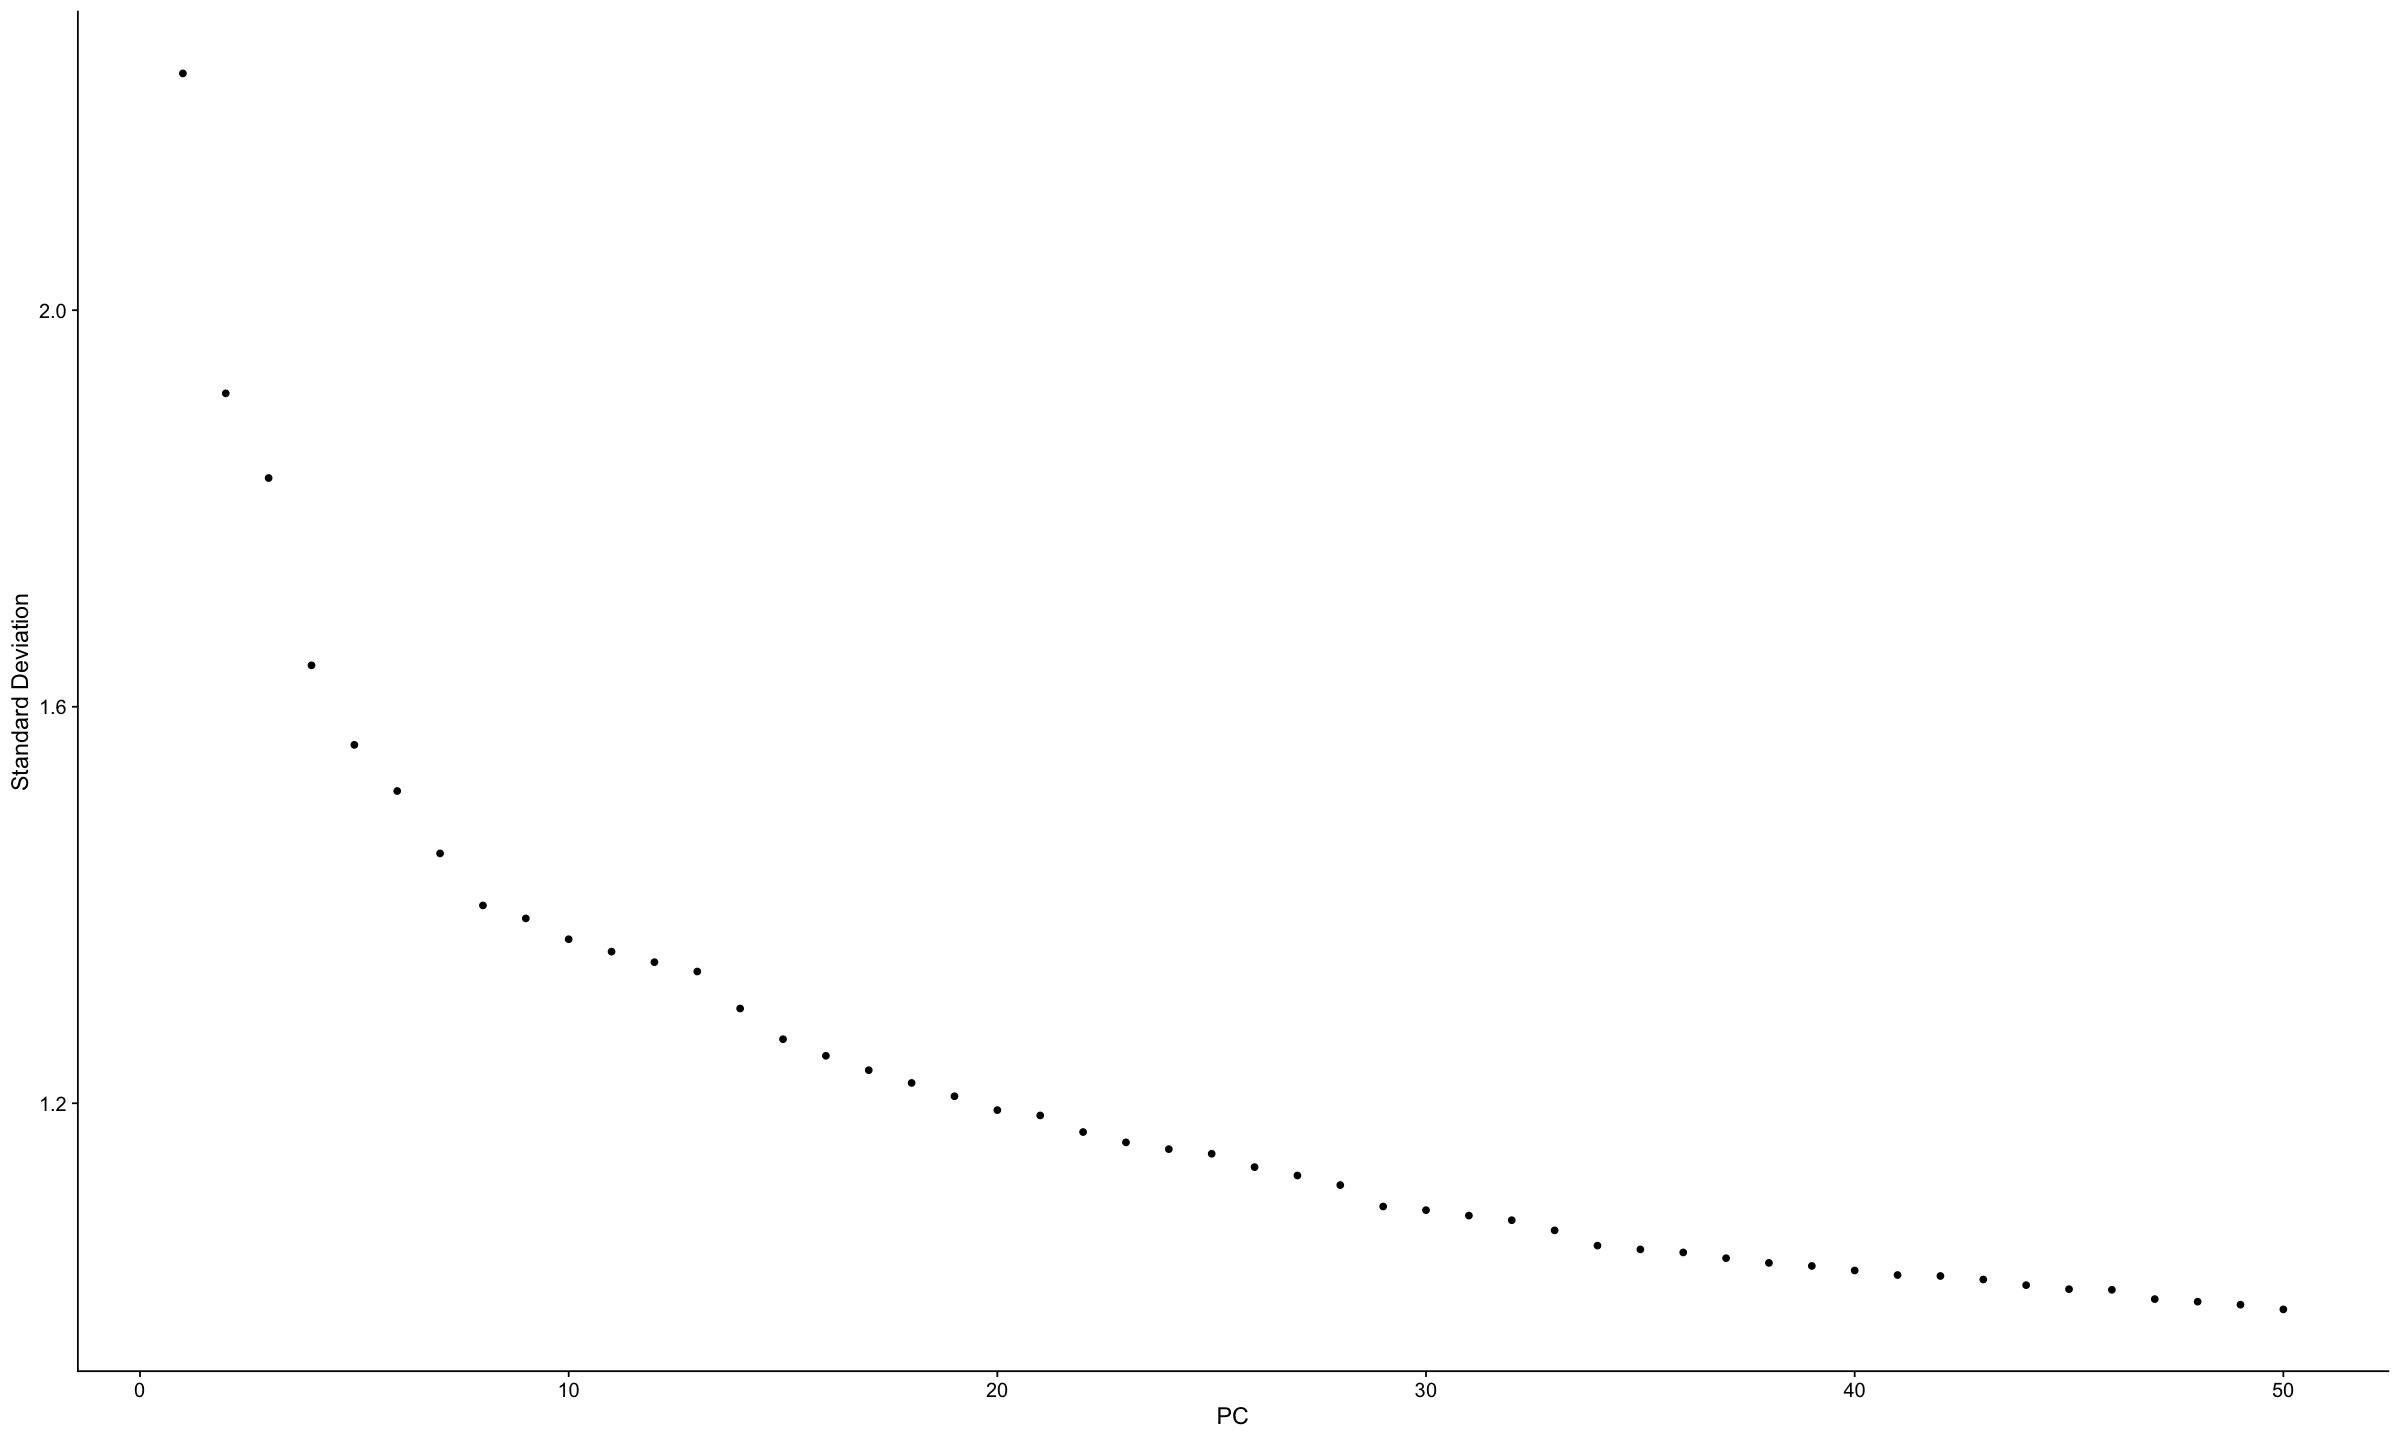

In [32]:
# Perform visualization for VectorTypes of interest
#VOI <- c("CD14 Mono—DC")
VOI <- "Adipocytes—Endothelial_Cells"
Idents(scc.sub) <- scc.sub@meta.data$VectorType
voi.data <- subset(scc.sub,idents = VOI)
voi.data <- ScaleData(voi.data)
voi.data <- FindVariableFeatures(voi.data,selection.method = "disp")
voi.data <- RunPCA(voi.data,npcs = 50)
ElbowPlot(voi.data,ndim=50)

In [36]:
voi.data$Condition <- factor(voi.data$Condition, 
                             levels = c("taPVAT_Control_24W_M", "taPVAT_HF_24W_M"), 
                             labels = c("PVAT Control 24W M", "PVAT HF 24W M"))

18:47:24 UMAP embedding parameters a = 0.9922 b = 1.112

18:47:24 Read 4483 rows and found 10 numeric columns

18:47:24 Using Annoy for neighbor search, n_neighbors = 30

18:47:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:47:24 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpcFZpAi/file23bd7053c0be

18:47:24 Searching Annoy index using 1 thread, search_k = 3000

18:47:25 Annoy recall = 100%

18:47:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:47:27 Initializing from normalized Laplacian + noise (using RSpectra)

18:47:27 Commencing optimization for 500 epochs, with 173964 positive edges

18:47:37 Optimization finished



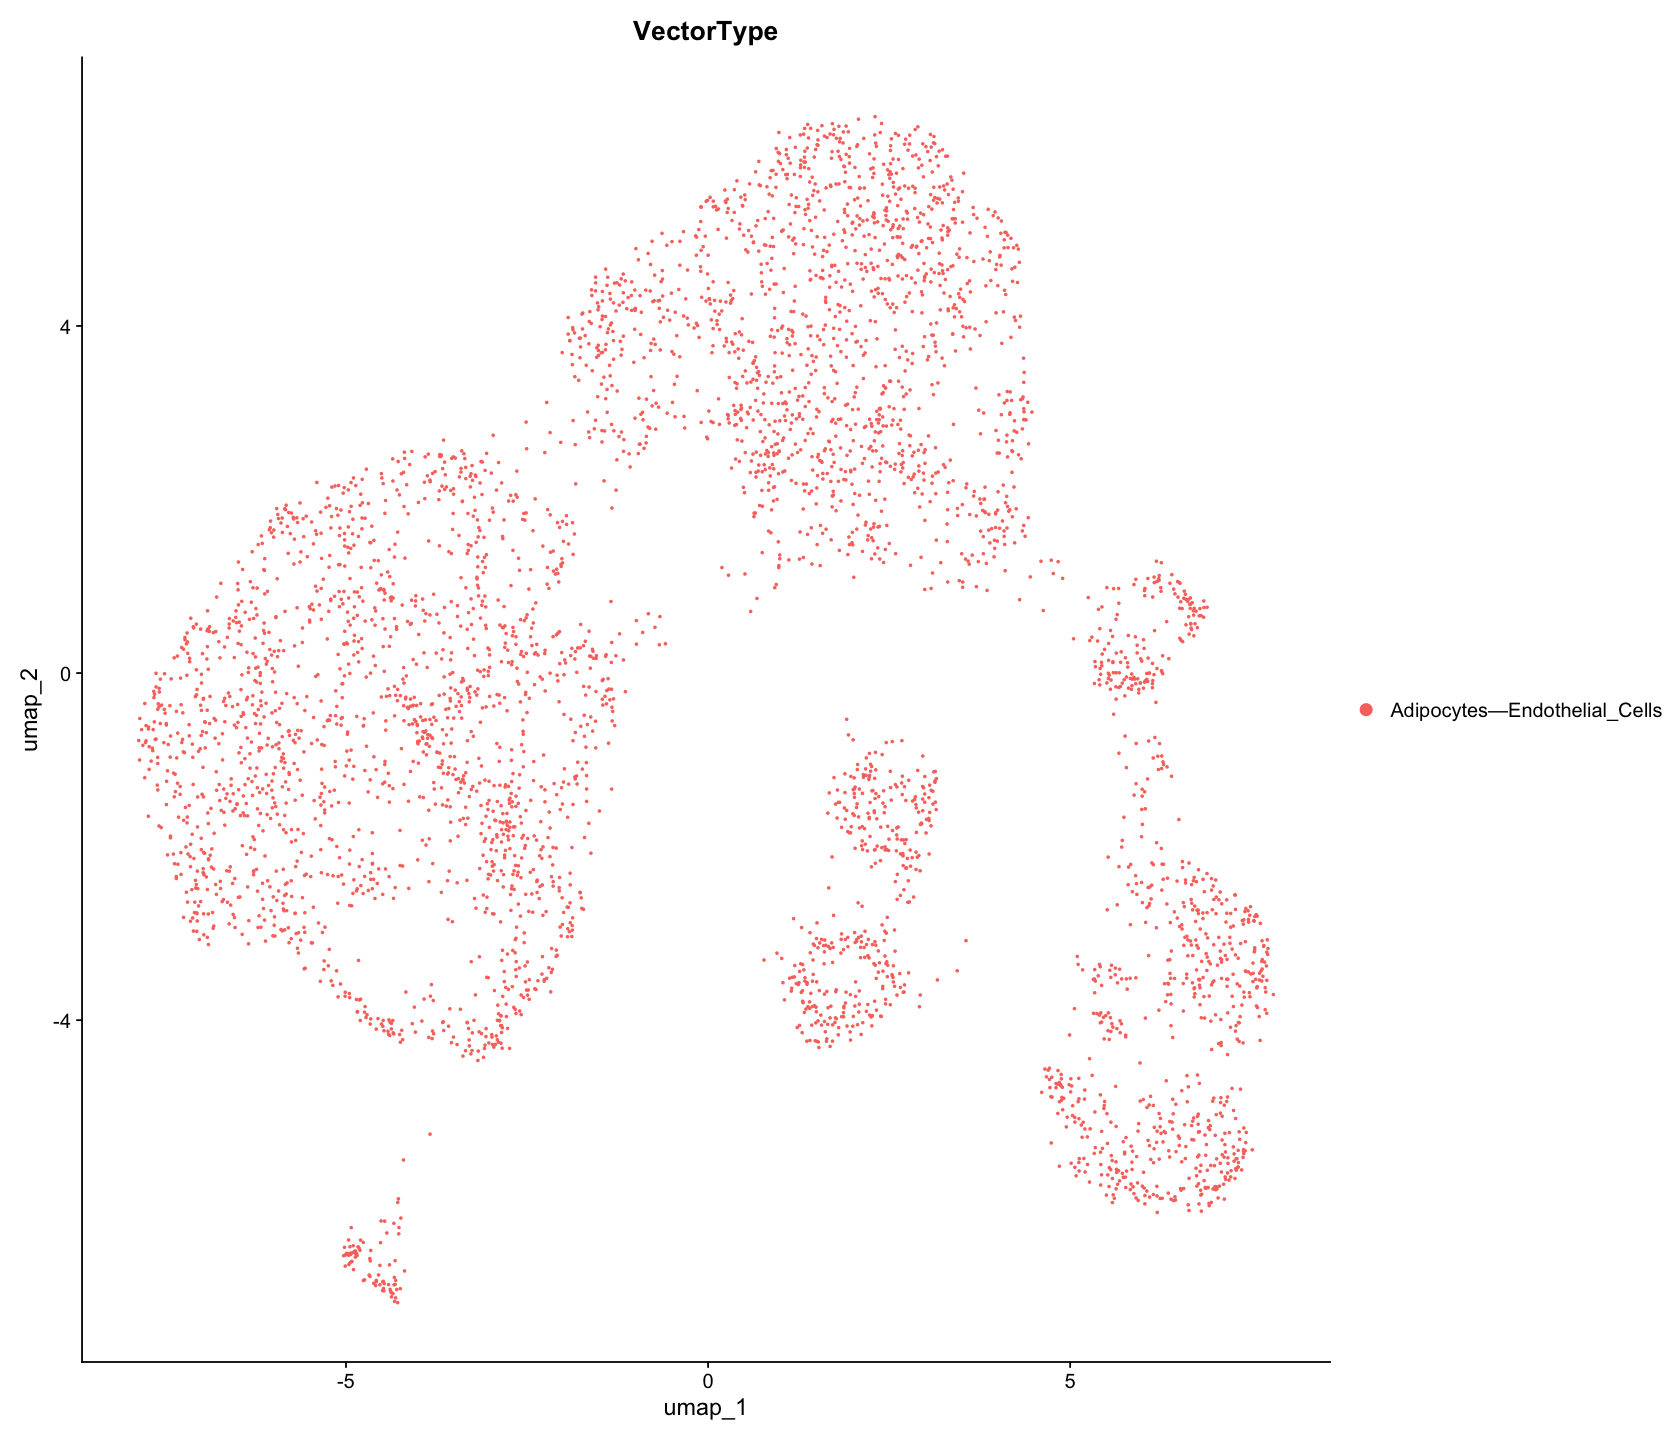

In [37]:
voi.data <- RunUMAP(voi.data,dims = 1:10)
DimPlot(voi.data,group.by = 'VectorType')

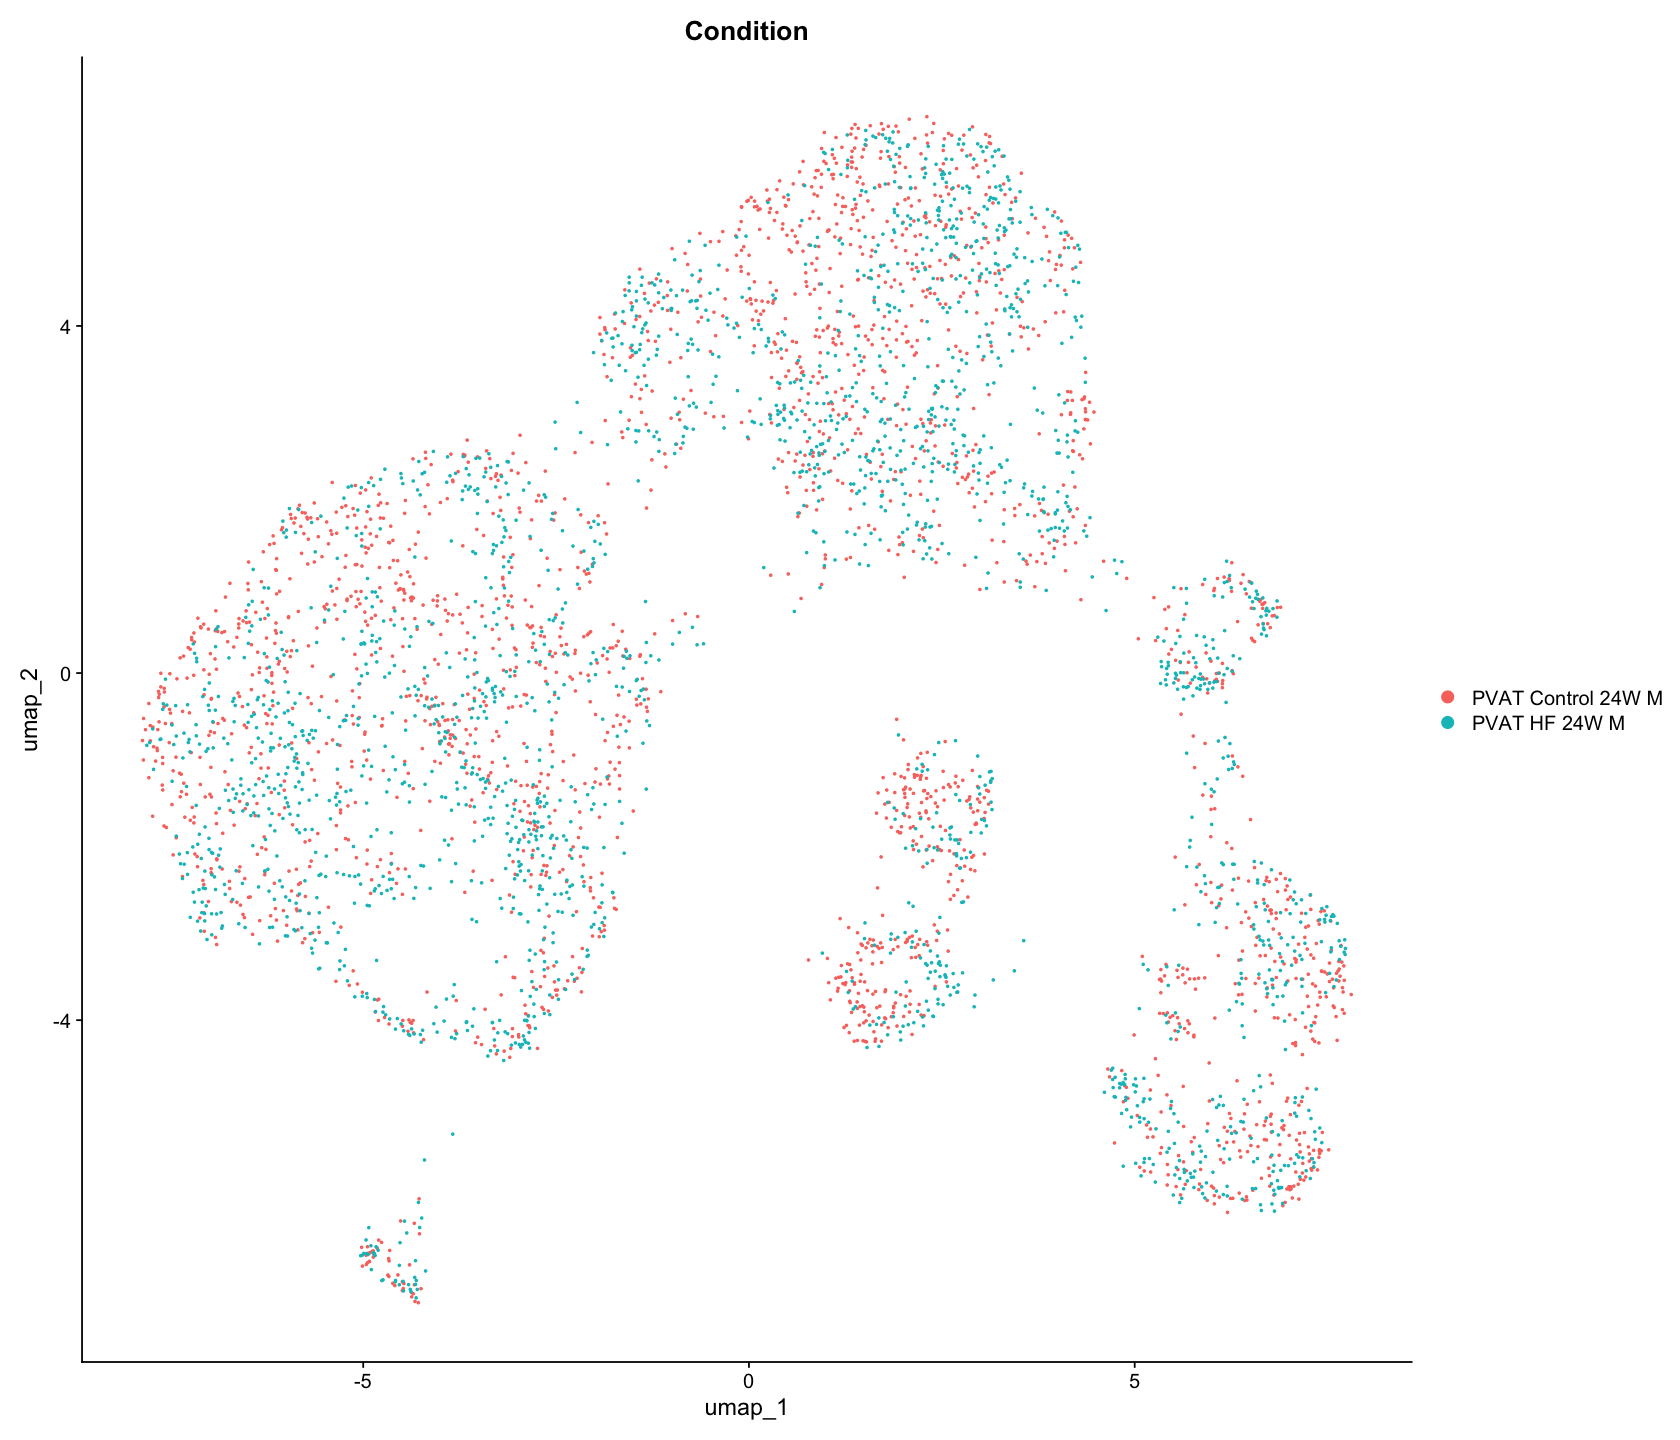

In [38]:
DimPlot(voi.data,group.by = 'Condition')

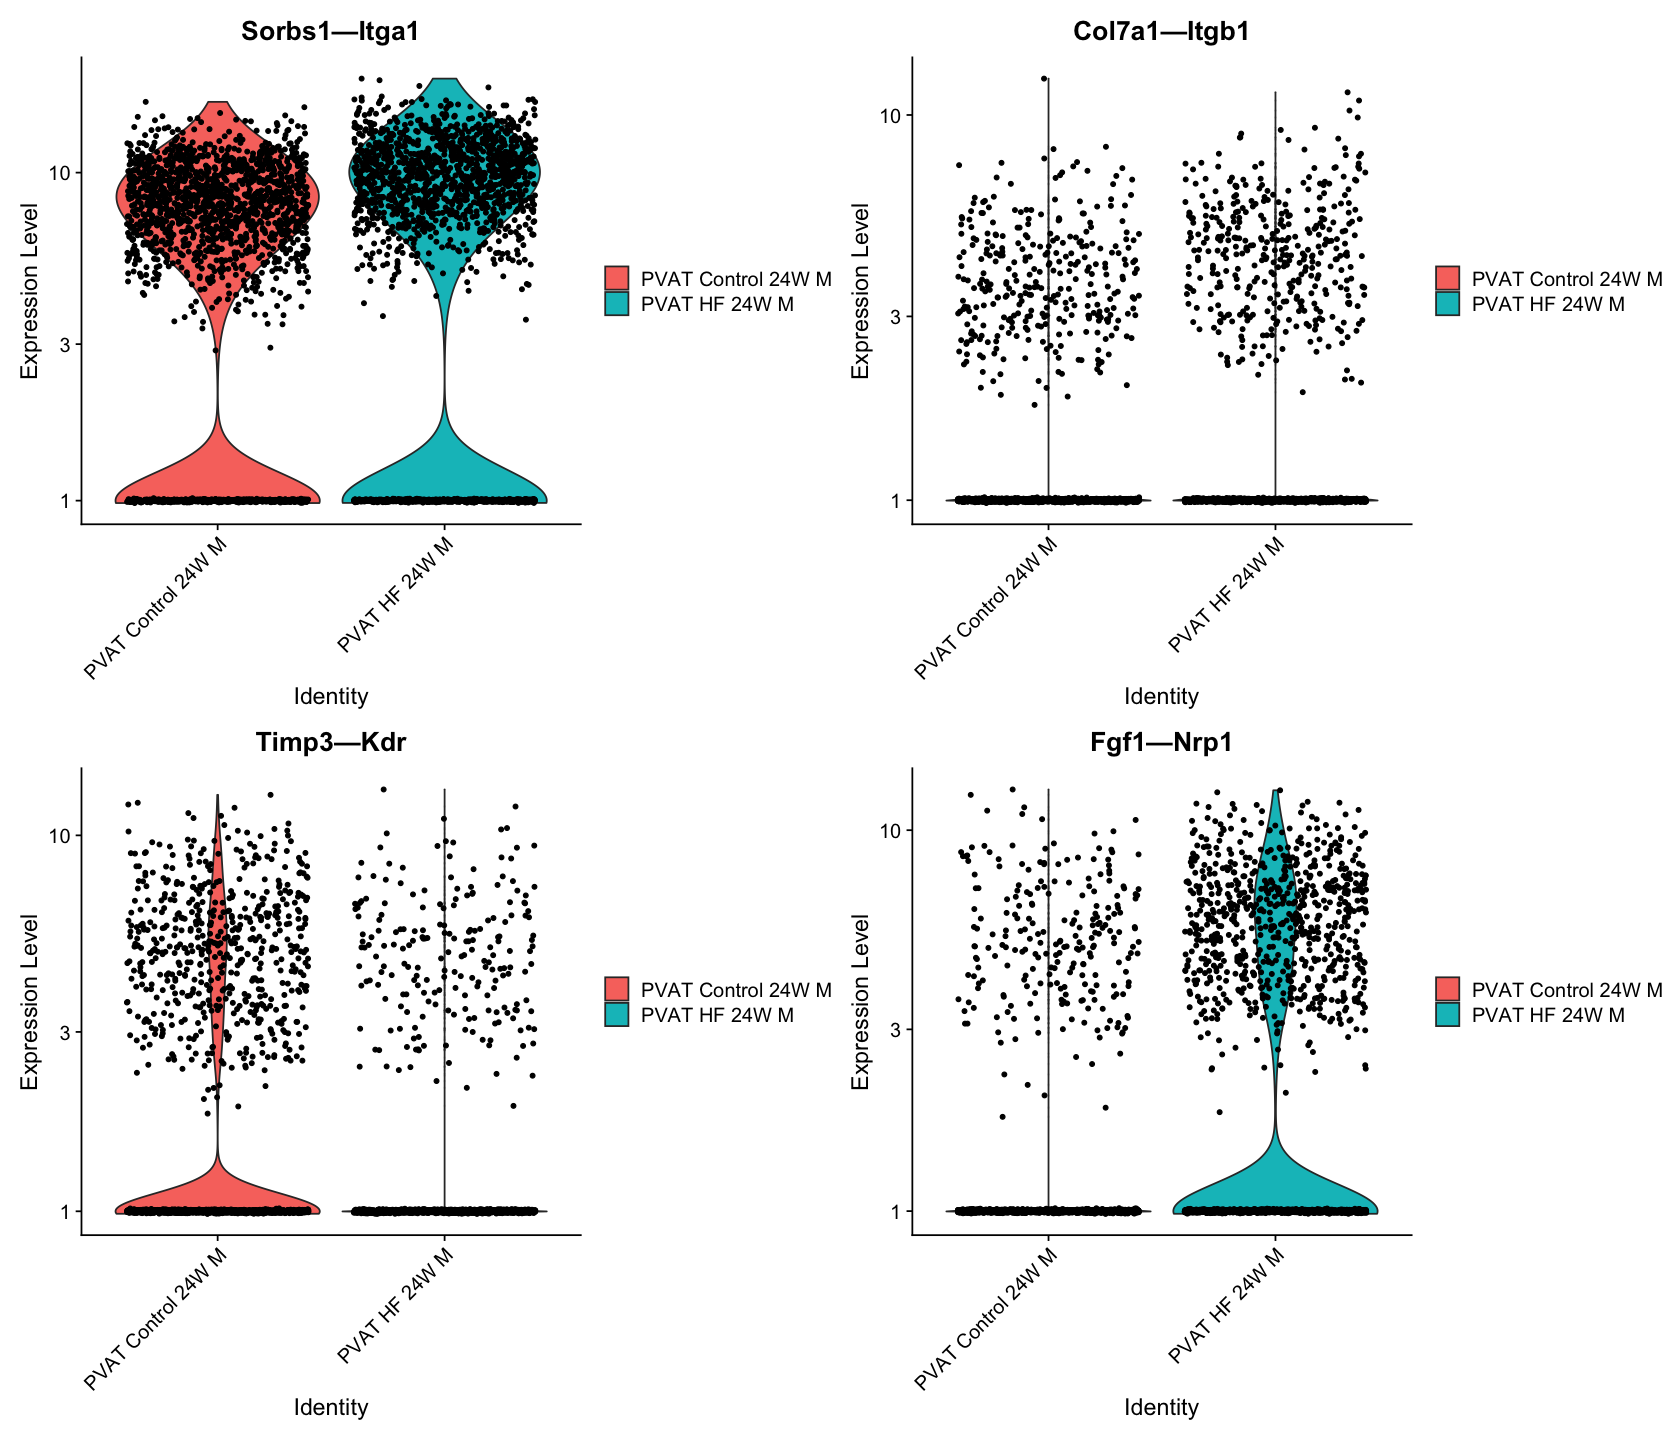

In [40]:
options(repr.plot.width=14, repr.plot.height=12)

plot1 <- VlnPlot(voi.data, features = 'Sorbs1—Itga1', log = TRUE, group.by = 'Condition')
plot2 <- VlnPlot(voi.data, features = 'Col7a1—Itgb1', log = TRUE, group.by = 'Condition')
plot3 <- VlnPlot(voi.data, features =  , log = TRUE, group.by = 'Condition')
plot4 <- VlnPlot(voi.data, features = 'Fgf1—Nrp1', log = TRUE, group.by = 'Condition')
plot <- (plot1 | plot2) / (plot3 | plot4)
plot

ggsave("Adipocytes to Endothelial Expression of Ligand-Receptor Pairs ('Sorbs1—Itga1', 'Col7a1—Itgb1', 'Timp3—Kdr', 'Fgf1—Nrp1') in 24-Week Male PVAT Control.pdf", plot = plot, width = 14, height = 12, dpi = 600)
ggsave("Adipocytes to Endothelial Expression of Ligand-Receptor Pairs ('Sorbs1—Itga1', 'Col7a1—Itgb1', 'Timp3—Kdr', 'Fgf1—Nrp1') in 24-Week Male PVAT Control.jpg", plot = plot, width = 14, height = 12, dpi = 600)


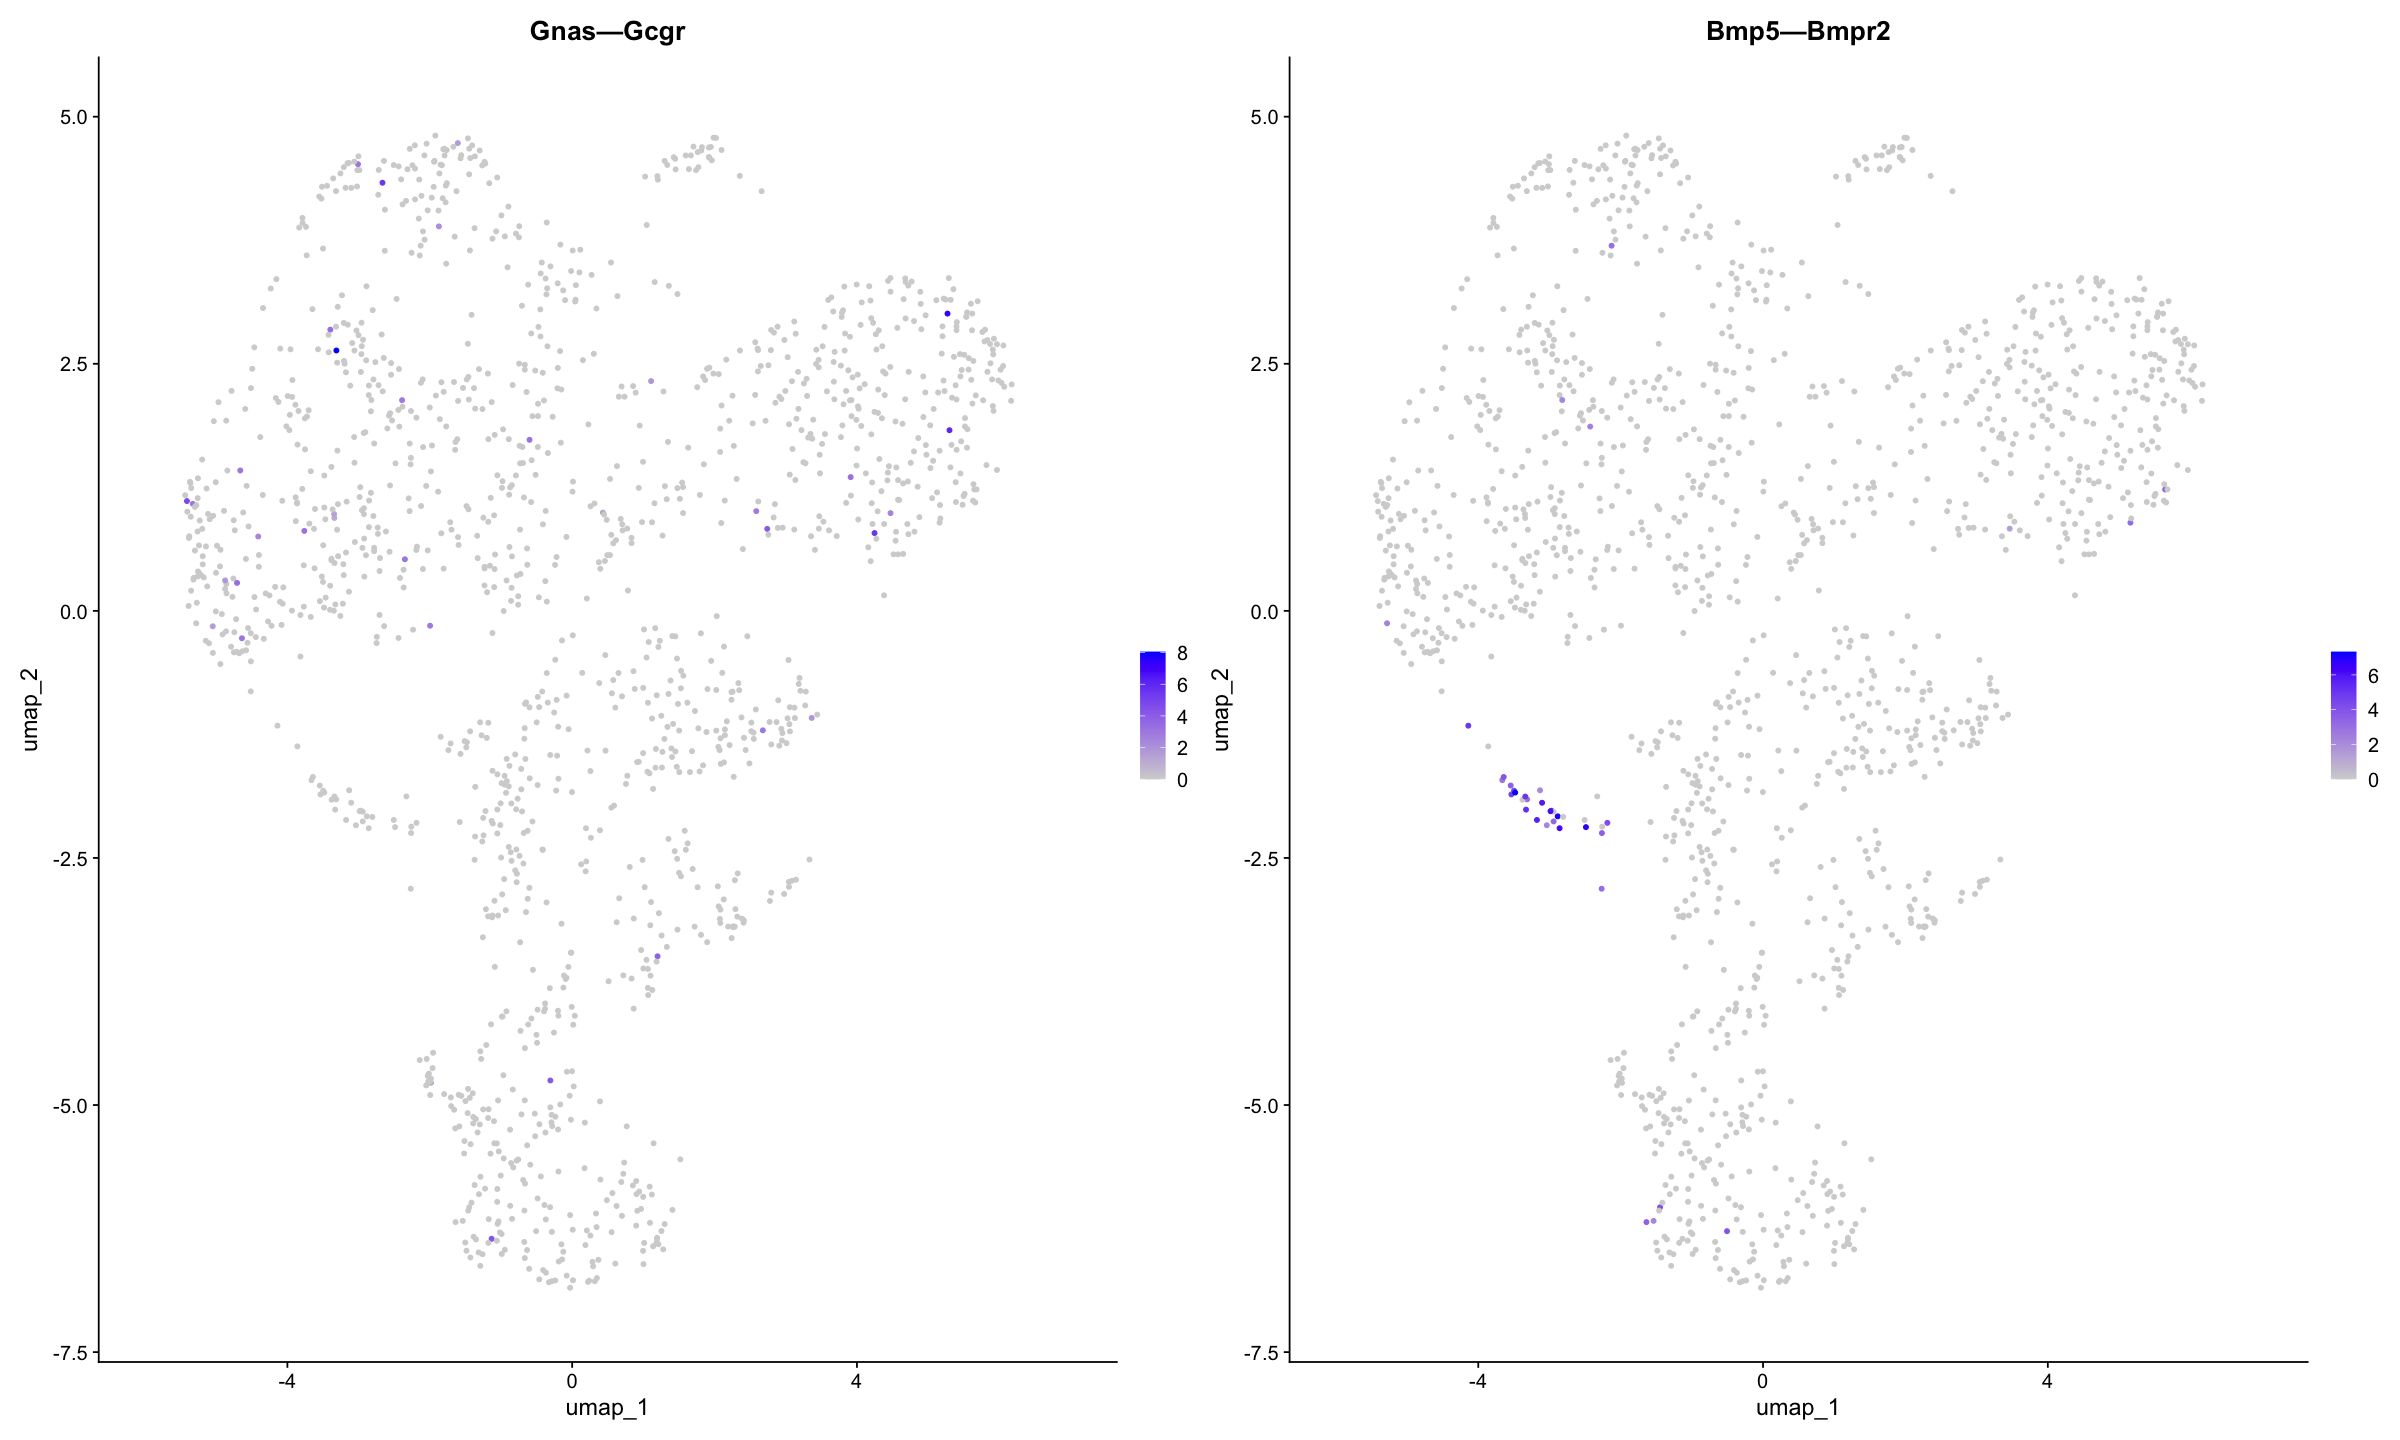

In [33]:
FeaturePlot(voi.data,
            features = c('Gnas—Gcgr','Bmp5—Bmpr2', 'Col11a1—Itgb1'),max.cutoff = 150)

In [34]:
voi.data <- JoinLayers(object = voi.data, assay = "CellToCell", layers = c("data", "scale.data"))

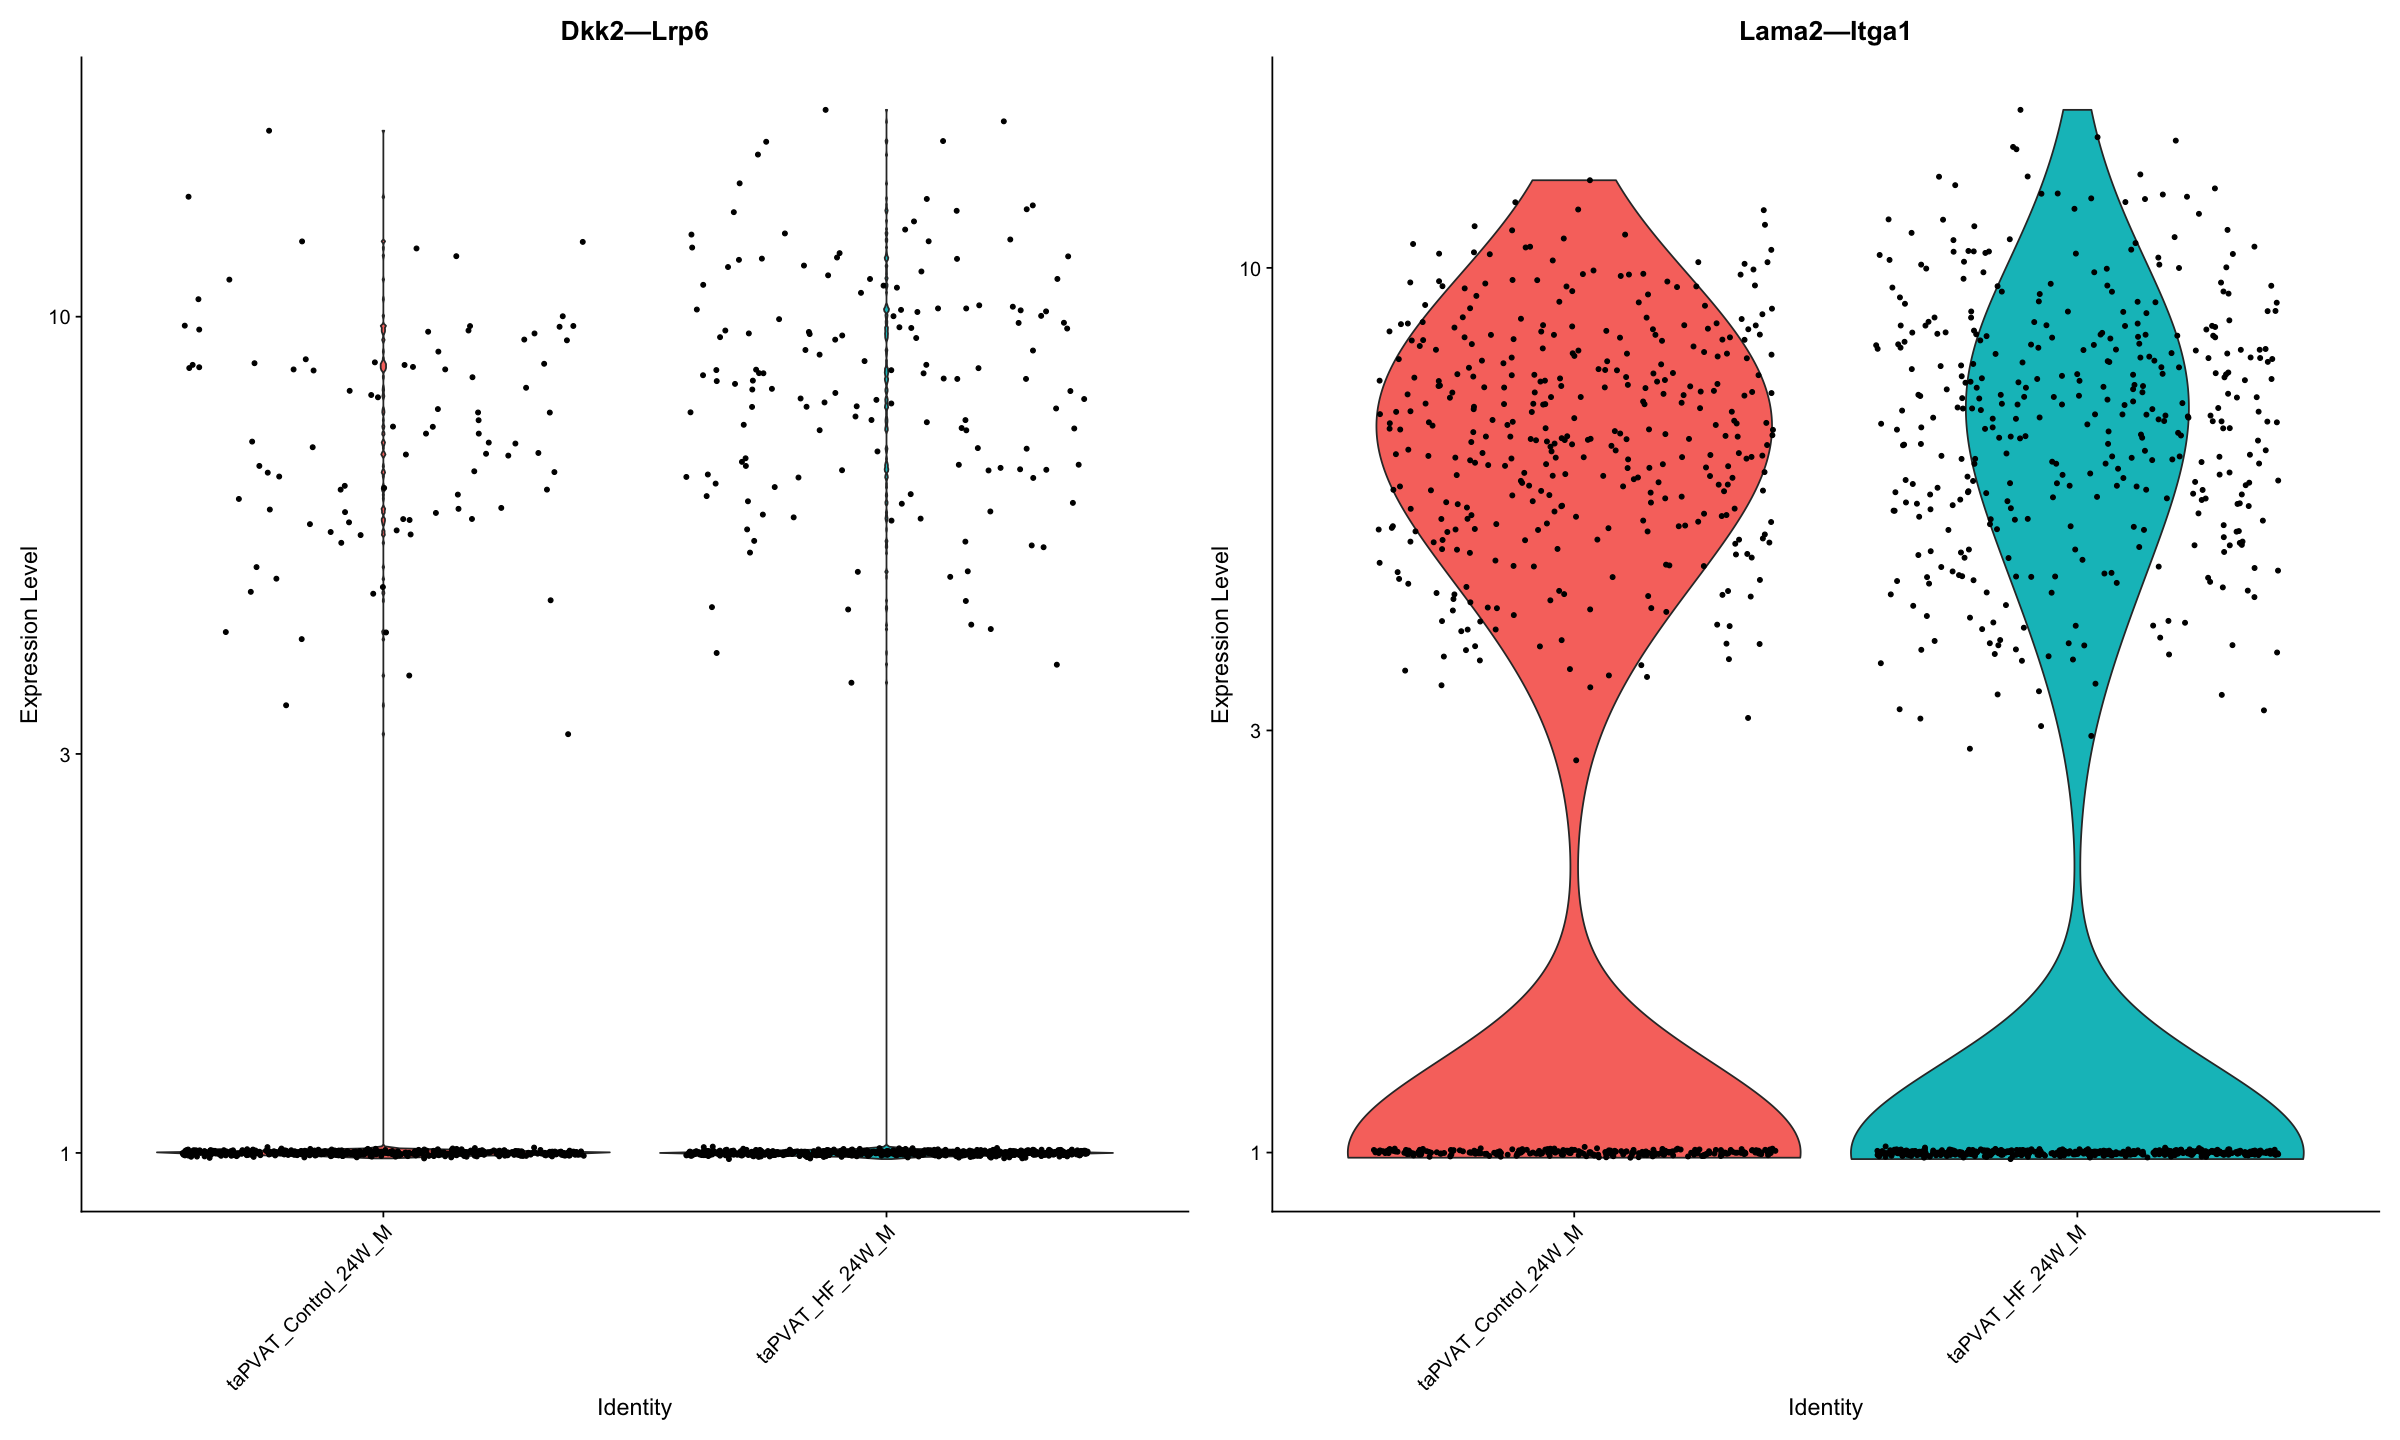

In [35]:
VlnPlot(voi.data,
            features = c('Dkk2—Lrp6','Lama2—Itga1'),log = T,group.by = 'Condition')

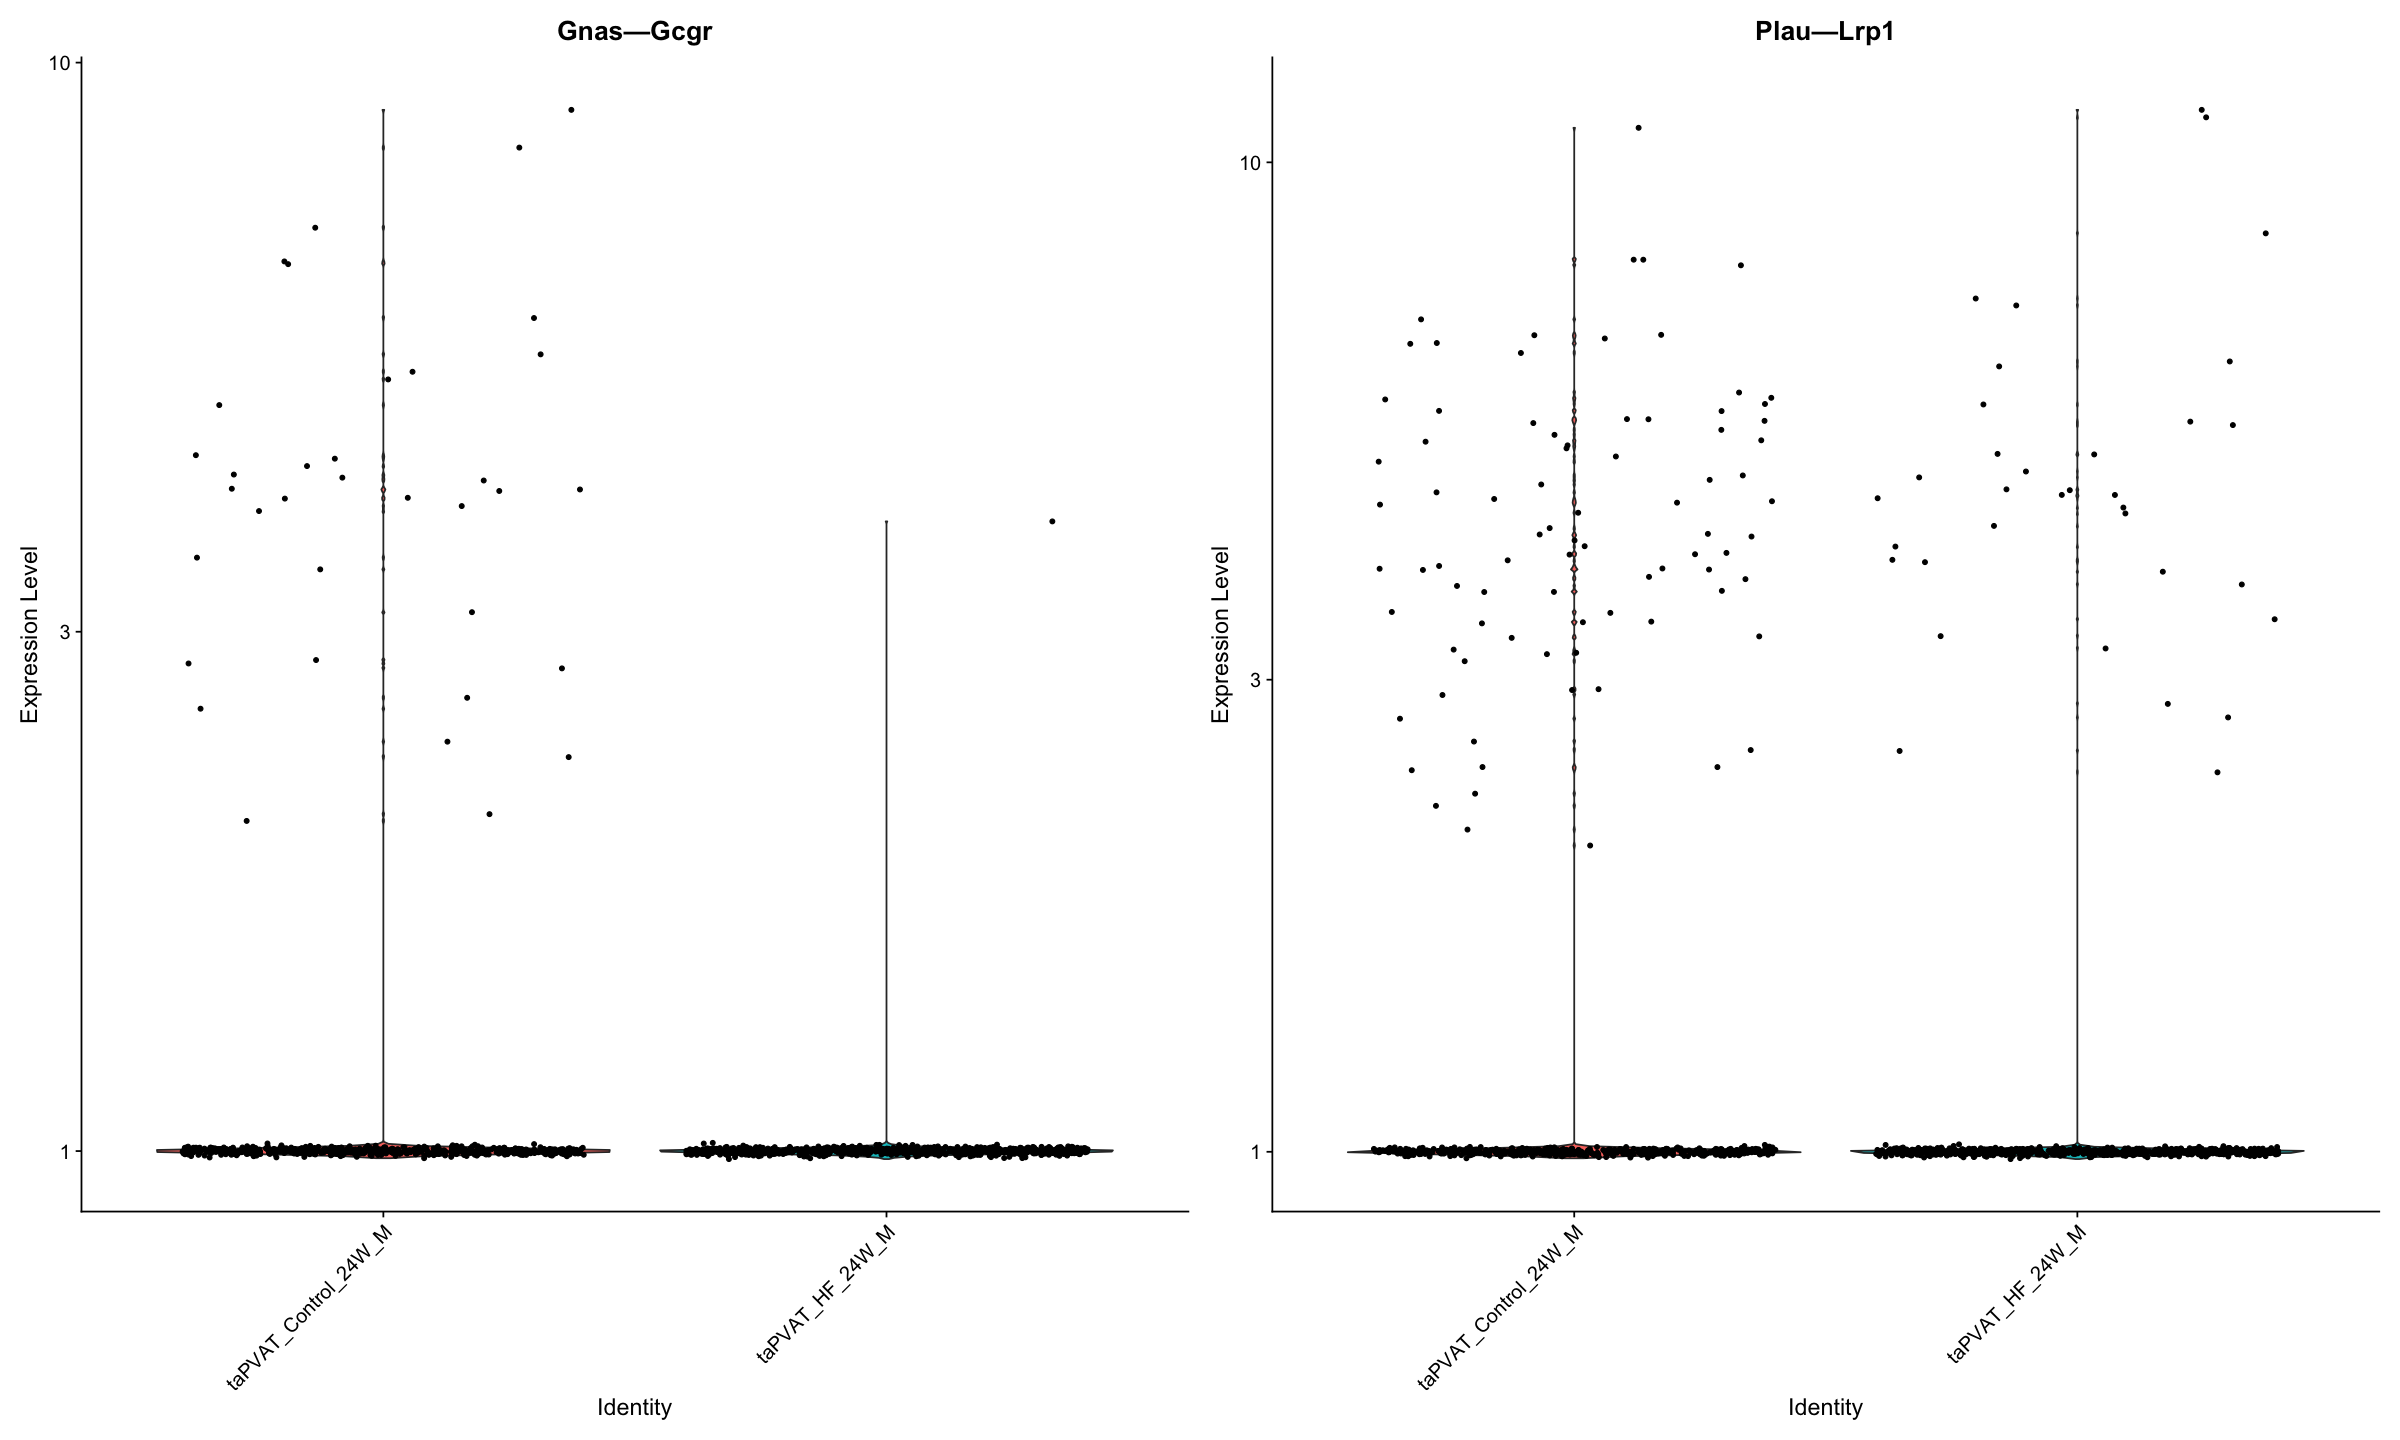

In [36]:
VlnPlot(voi.data,
            features = c('Gnas—Gcgr','Plau—Lrp1'),log = T,group.by = 'Condition')

In [37]:
top10

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster             
1  2.196617e-42  3.075760  0.833 0.697 1.996725e-39 taPVAT_Control_24W_M
2  2.567329e-39  2.832051  0.313 0.142 2.333702e-36 taPVAT_Control_24W_M
3  2.303382e-18  2.644641  0.122 0.049 2.093774e-15 taPVAT_Control_24W_M
4  5.590058e-12  3.628258  0.030 0.003 5.081363e-09 taPVAT_Control_24W_M
5  1.301011e-10 10.308004  0.019 0.000 1.182619e-07 taPVAT_Control_24W_M
6  1.842212e-09  2.309678  0.145 0.090 1.674570e-06 taPVAT_Control_24W_M
7  3.690136e-09  4.549226  0.023 0.003 3.354333e-06 taPVAT_Control_24W_M
8  1.865550e-08  8.952229  0.014 0.000 1.695785e-05 taPVAT_Control_24W_M
9  2.652878e-05  4.621825  0.010 0.001 2.411466e-02 taPVAT_Control_24W_M
10 7.344122e-03  1.639704  0.024 0.013 1.000000e+00 taPVAT_Control_24W_M
11 2.293096e-24  3.776533  0.090 0.021 2.084424e-21 taPVAT_HF_24W_M     
12 1.678017e-09  3.742060  0.597 0.634 1.525318e-06 taPVAT_HF_24W_M     
13 1.055711e-05  2.817732  0.260 0.218 9.596415e-03 taPVAT_HF_24W_M     
14 1.396237e-04  8.821882  0.010 0.001 1.269179e-01 taPVAT_HF_24W_M     
15 5.364588e-04  3.397679  0.014 0.004 4.876410e-01 taPVAT_HF_24W_M     
16 1.590749e-03  3.419854  0.028 0.015 1.000000e+00 taPVAT_HF_24W_M     
17 2.947592e-03  4.138958  0.023 0.012 1.000000e+00 taPVAT_HF_24W_M     
18 5.321985e-03  5.296034  0.072 0.054 1.000000e+00 taPVAT_HF_24W_M     
19 8.216708e-03  2.724254  0.035 0.022 1.000000e+00 taPVAT_HF_24W_M     
20 8.400920e-03  3.778226  0.023 0.013 1.000000e+00 taPVAT_HF_24W_M     
   gene        
1  Vegfa—Nrp1  
2  Pdgfc—Flt1  
3  Pkm—Cd44    
4  Jag2—Notch4 
5  Lamc3—Itga6 
6  Lpl—Cd44    
7  Jag2—Notch1 
8  Lamc3—Itgb1 
9  Gnas—Adora1 
10 Lamb1—Itgav 
11 Fgf1—Fgfr2  
12 Sorbs1—Itga1
13 Col5a1—Itga1
14 Tfpi—F3     
15 Nrg2—Erbb4  
16 Col5a2—Itgb1
17 Fgf18—Fgfr2 
18 Angpt1—Itga5
19 Col5a2—Itga1
20 Adam12—Itga9

In [36]:
voi.data@assays

$CellToCell
Assay (v5) data with 909 features for 1440 cells
Top 10 variable features:
 Dkk2—Lrp6, Sema3c—Nrp1, Igfbp4—Lrp6, Ntf3—Ntrk3, Fn1—Tshr,
Col4a1—Itgb1, Fgf7—Nrp1, Gnas—Adcy9, Lama2—Itga1, Vegfa—Nrp1 
Layers:
 data, counts.1, counts.2, scale.data 


In [37]:
'Plau—Itgav'  %in%  rownames(voi.data@assays$CellToCell)

[1] TRUE